# Setting up

In [ ]:
# import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.spatial import KDTree
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

FILE_PATH = '/content/drive/My Drive/CS5228_Project/data/'

df_train = pd.read_csv(FILE_PATH + 'train.csv')
df_test = pd.read_csv(FILE_PATH + 'test.csv')

# auxiliary data
df_shopping_malls = pd.read_csv(FILE_PATH + 'auxiliary-data/sg-shopping-malls.csv')
df_pri_schools = pd.read_csv(FILE_PATH + 'auxiliary-data/sg-primary-schools.csv')
df_sec_schools = pd.read_csv(FILE_PATH + 'auxiliary-data/sg-secondary-schools.csv')
df_mrt_stations = pd.read_csv(FILE_PATH + 'auxiliary-data/sg-mrt-stations.csv')
df_hdb_details = pd.read_csv(FILE_PATH + 'auxiliary-data/sg-hdb-block-details.csv')
df_hawkers = pd.read_csv(FILE_PATH + 'auxiliary-data/sg-gov-hawkers.csv')

Mounted at /content/drive


# EDA: Primary dataset features

In [ ]:
print(df_train.shape)
print(df_test.shape)

(162691, 11)
(50000, 10)


In [ ]:
df_train.head(5)

,MONTH,TOWN,FLAT_TYPE,BLOCK,STREET,FLOOR_RANGE,FLOOR_AREA_SQM,FLAT_MODEL,ECO_CATEGORY,LEASE_COMMENCE_DATA,RESALE_PRICE
0,2020-10,woodlands,4 room,681B,woodlands drive 62,07 to 09,102.0,premium apartment,uncategorized,2000,420000.0
1,2021-07,bishan,4 room,264,bishan street 24,07 to 09,104.0,model a,uncategorized,1992,585000.0
2,2021-05,bukit panjang,4 room,520,jelapang road,19 to 21,102.0,model a,uncategorized,1998,450000.0
3,2021-08,punggol,4 room,121B,edgedale plains,16 to 18,93.0,model a,uncategorized,2017,465000.0
4,2023-05,hougang,5 room,997B,Buangkok Crescent,10 to 12,113.0,improved,uncategorized,2018,710000.0


## Check missing values and duplicates

In [ ]:
# Missing values per column
missing = df_train.isna().sum().to_frame('missing_count')
missing['missing_pct'] = (missing['missing_count'] / len(df_train)).round(4)
print(missing.sort_values('missing_count', ascending=False))

# Checking for exact duplicate rows
dup_mask = df_train.duplicated(keep=False)
print("\nExact duplicate rows:", int(dup_mask.sum()))

                     missing_count  missing_pct
MONTH                            0          0.0
TOWN                             0          0.0
FLAT_TYPE                        0          0.0
BLOCK                            0          0.0
STREET                           0          0.0
FLOOR_RANGE                      0          0.0
FLOOR_AREA_SQM                   0          0.0
FLAT_MODEL                       0          0.0
ECO_CATEGORY                     0          0.0
LEASE_COMMENCE_DATA              0          0.0
RESALE_PRICE                     0          0.0

Exact duplicate rows: 241


In [ ]:
# Drop exact duplicate rows
before = len(df_train)
df_train = df_train.drop_duplicates().reset_index(drop=True)
after = len(df_train)

print(f"Dropped {before - after} duplicate rows. New shape: {df_train.shape}")

Dropped 121 duplicate rows. New shape: (162570, 11)


## Check for inconsistencies in categorical features

In [ ]:
for col in ['TOWN', 'FLAT_TYPE', 'FLAT_MODEL']:
    print(f"\nColumn: {col}")
    print(df_train[col].unique())


Column: TOWN
['woodlands' 'bishan' 'bukit panjang' 'punggol' 'hougang' 'clementi'
 'bedok' 'yishun' 'sengkang' 'queenstown' 'bukit batok' 'pasir ris'
 'toa payoh' 'geylang' 'tampines' 'bukit merah' 'ang mo kio' 'sembawang'
 'choa chu kang' 'jurong west' 'kallang/whampoa' 'serangoon'
 'central area' 'jurong east' 'marine parade' 'bukit timah']

Column: FLAT_TYPE
['4 room' '5 room' '3 room' '5-room' '3-room' 'executive' '4-room'
 '2-room' '2 room' '1 room' 'multi generation' '1-room']

Column: FLAT_MODEL
['premium apartment' 'model a' 'improved' 'new generation' 'standard'
 'maisonette' 'dbss' 'simplified' 'apartment' 'model a2' 'type s1'
 'adjoined flat' 'model a maisonette' 'type s2' '3gen' '2 room' 'terrace'
 'premium apartment loft' 'premium maisonette' 'multi generation'
 'improved maisonette']


In [ ]:
# Fix inconsistencies in FLAT_TYPE
import re
def to_kebab_case(s):
  s = s.lower()
  s = re.sub(r"\s+", "-", s.strip())
  return s

df_train['FLAT_TYPE'] = df_train['FLAT_TYPE'].apply(to_kebab_case)

In [ ]:
print(df_train['FLAT_TYPE'].unique())

['4-room' '5-room' '3-room' 'executive' '2-room' '1-room'
 'multi-generation']


## Unit resale price (as target)

In [ ]:
# Add column for resale price per sqm
df_train["resale_price_per_sqm"] = df_train["RESALE_PRICE"] / df_train['FLOOR_AREA_SQM']

array([[<Axes: title={'center': 'resale_price_per_sqm'}>]], dtype=object)

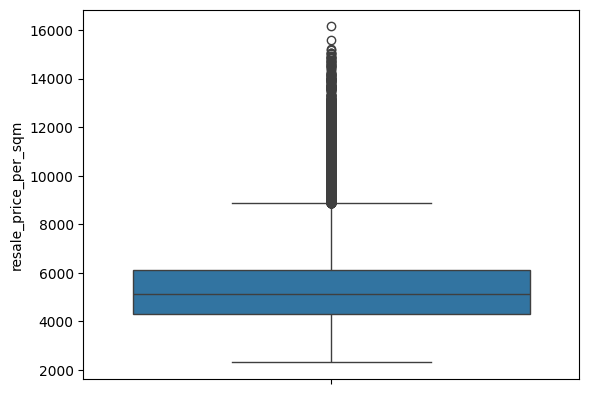

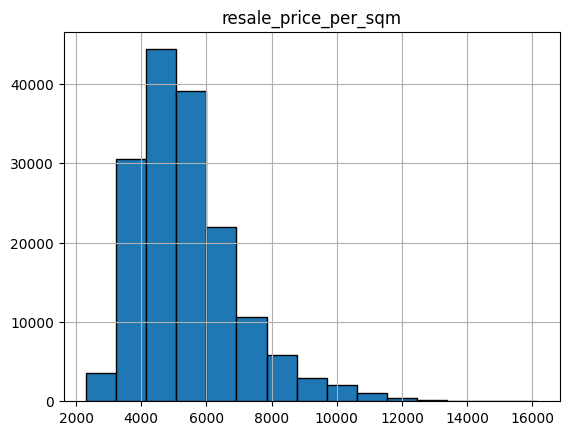

In [ ]:
sns.boxplot(df_train["resale_price_per_sqm"])

df_train.hist(column='resale_price_per_sqm', bins=15, edgecolor='black')

## Time feature

In [ ]:
# Helper functions
def add_time_feature(df):
  df["date"] = pd.to_datetime(df["MONTH"])
  df["year"] = df["date"].dt.year
  df["month_num"] = df["date"].dt.month

  # Continuous trend feature
  df["months_since_start"] = (df["year"] - df["year"].min()) * 12 + df["month_num"]

  return df

In [ ]:
df_train = add_time_feature(df_train)
df_train.head()

,MONTH,TOWN,FLAT_TYPE,BLOCK,STREET,FLOOR_RANGE,FLOOR_AREA_SQM,FLAT_MODEL,ECO_CATEGORY,LEASE_COMMENCE_DATA,RESALE_PRICE,resale_price_per_sqm,date,year,month_num,months_since_start
0,2020-10,woodlands,4-room,681B,woodlands drive 62,07 to 09,102.0,premium apartment,uncategorized,2000,420000.0,4117.647059,2020-10-01,2020,10,46
1,2021-07,bishan,4-room,264,bishan street 24,07 to 09,104.0,model a,uncategorized,1992,585000.0,5625.000000,2021-07-01,2021,7,55
2,2021-05,bukit panjang,4-room,520,jelapang road,19 to 21,102.0,model a,uncategorized,1998,450000.0,4411.764706,2021-05-01,2021,5,53
3,2021-08,punggol,4-room,121B,edgedale plains,16 to 18,93.0,model a,uncategorized,2017,465000.0,5000.000000,2021-08-01,2021,8,56
4,2023-05,hougang,5-room,997B,Buangkok Crescent,10 to 12,113.0,improved,uncategorized,2018,710000.0,6283.185841,2023-05-01,2023,5,77


/tmp/ipython-input-383389176.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='date', y='resale_price_per_sqm', data=df_train, ci=None)


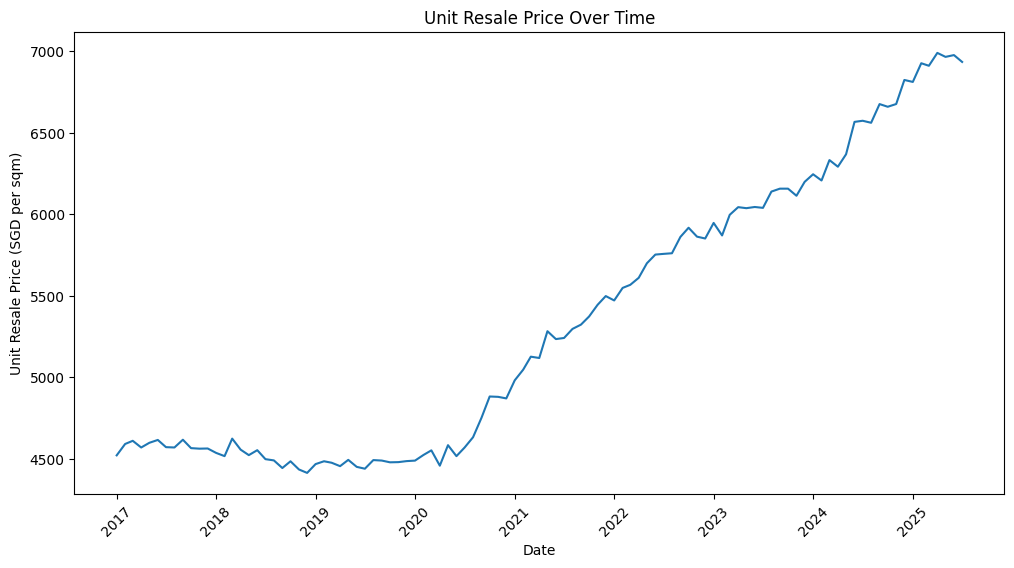

/tmp/ipython-input-383389176.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='year', y='resale_price_per_sqm', data=yearly_avg, palette='Blues_d')


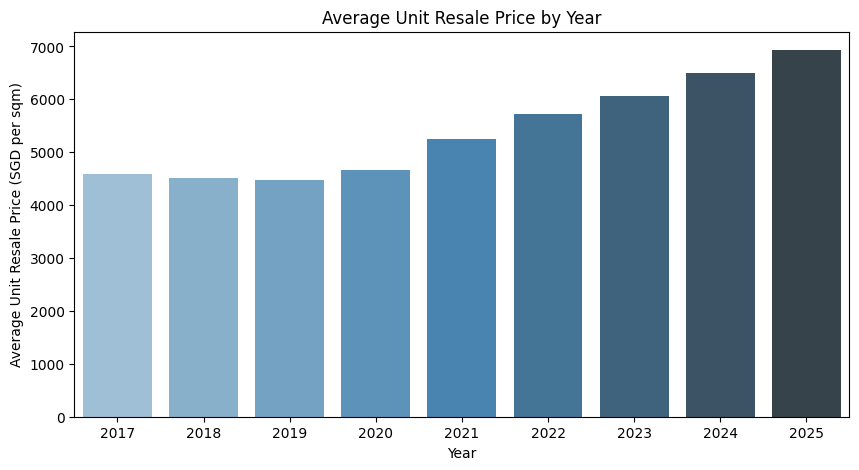

/tmp/ipython-input-383389176.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month_num', y='resale_price_per_sqm', data=df_train, palette='Pastel1')


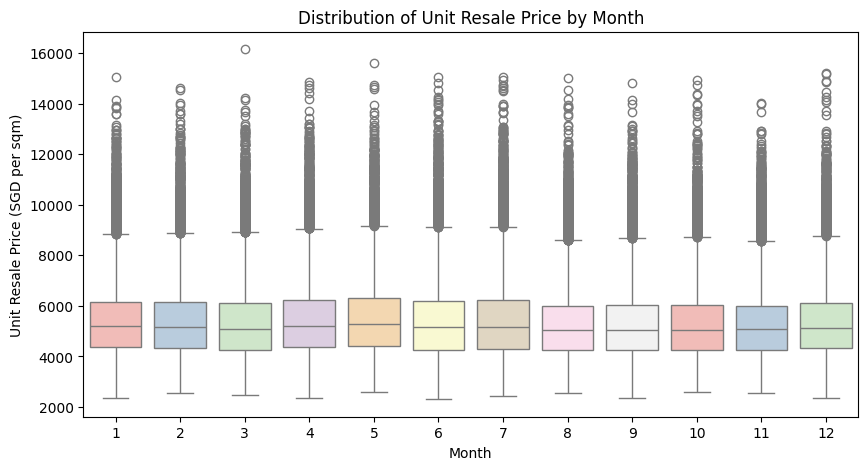

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot unit resale price over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='resale_price_per_sqm', data=df_train, ci=None)
plt.title('Unit Resale Price Over Time')
plt.xlabel('Date')
plt.ylabel('Unit Resale Price (SGD per sqm)')
plt.xticks(rotation=45)
plt.show()

# Average unit resale price by year
yearly_avg = df_train.groupby('year')['resale_price_per_sqm'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(x='year', y='resale_price_per_sqm', data=yearly_avg, palette='Blues_d')
plt.title('Average Unit Resale Price by Year')
plt.xlabel('Year')
plt.ylabel('Average Unit Resale Price (SGD per sqm)')
plt.show()

# Boxplot to see seasonal variation (month)
plt.figure(figsize=(10, 5))
sns.boxplot(x='month_num', y='resale_price_per_sqm', data=df_train, palette='Pastel1')
plt.title('Distribution of Unit Resale Price by Month')
plt.xlabel('Month')
plt.ylabel('Unit Resale Price (SGD per sqm)')
plt.show()

plt.tight_layout()
plt.show()

## Lease feature

In [ ]:
def add_lease_feature(df):
  # Flat age
  df["flat_age"] = df["year"] - df["LEASE_COMMENCE_DATA"]

  # Remaining lease (assuming 99 years)
  df["remaining_lease"] = 99 - df["flat_age"]
  df["short_lease_flag"] = (df["remaining_lease"] < 60).astype(int)

  # Non-linear effects
  df["log_remaining_lease"] = np.log1p(df["remaining_lease"].clip(lower=1))
  return df

In [ ]:
df_train = add_lease_feature(df_train)
df_train.head()

,MONTH,TOWN,FLAT_TYPE,BLOCK,STREET,FLOOR_RANGE,FLOOR_AREA_SQM,FLAT_MODEL,ECO_CATEGORY,LEASE_COMMENCE_DATA,RESALE_PRICE,resale_price_per_sqm,date,year,month_num,months_since_start,flat_age,remaining_lease,short_lease_flag,log_remaining_lease
0,2020-10,woodlands,4-room,681B,woodlands drive 62,07 to 09,102.0,premium apartment,uncategorized,2000,420000.0,4117.647059,2020-10-01,2020,10,46,20,79,0,4.382027
1,2021-07,bishan,4-room,264,bishan street 24,07 to 09,104.0,model a,uncategorized,1992,585000.0,5625.000000,2021-07-01,2021,7,55,29,70,0,4.262680
2,2021-05,bukit panjang,4-room,520,jelapang road,19 to 21,102.0,model a,uncategorized,1998,450000.0,4411.764706,2021-05-01,2021,5,53,23,76,0,4.343805
3,2021-08,punggol,4-room,121B,edgedale plains,16 to 18,93.0,model a,uncategorized,2017,465000.0,5000.000000,2021-08-01,2021,8,56,4,95,0,4.564348
4,2023-05,hougang,5-room,997B,Buangkok Crescent,10 to 12,113.0,improved,uncategorized,2018,710000.0,6283.185841,2023-05-01,2023,5,77,5,94,0,4.553877


/tmp/ipython-input-677620804.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


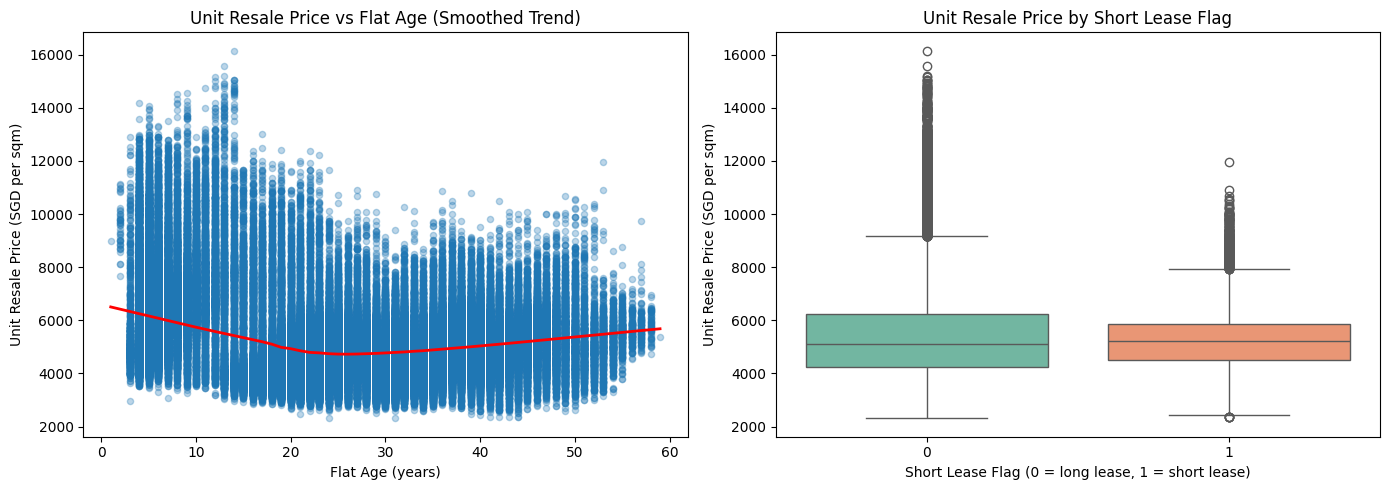

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,5))

# 1️. Smoothed scatter plot: flat_age vs resale_price_per_sqm
plt.subplot(1,2,1)
sns.regplot(
    x='flat_age',
    y='resale_price_per_sqm',
    data=df_train,
    lowess=True,              # smooth trend line
    scatter_kws={'alpha':0.3, 's':20},
    line_kws={'color':'red', 'lw':2}
)
plt.title('Unit Resale Price vs Flat Age (Smoothed Trend)')
plt.xlabel('Flat Age (years)')
plt.ylabel('Unit Resale Price (SGD per sqm)')

# 2. Boxplot: short_lease_flag vs resale_price_per_sqm
plt.subplot(1,2,2)
sns.boxplot(
    x='short_lease_flag',
    y='resale_price_per_sqm',
    data=df_train,
    palette='Set2'
)
plt.title('Unit Resale Price by Short Lease Flag')
plt.xlabel('Short Lease Flag (0 = long lease, 1 = short lease)')
plt.ylabel('Unit Resale Price (SGD per sqm)')

plt.tight_layout()
plt.show()

## Flat features

/tmp/ipython-input-1641379615.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


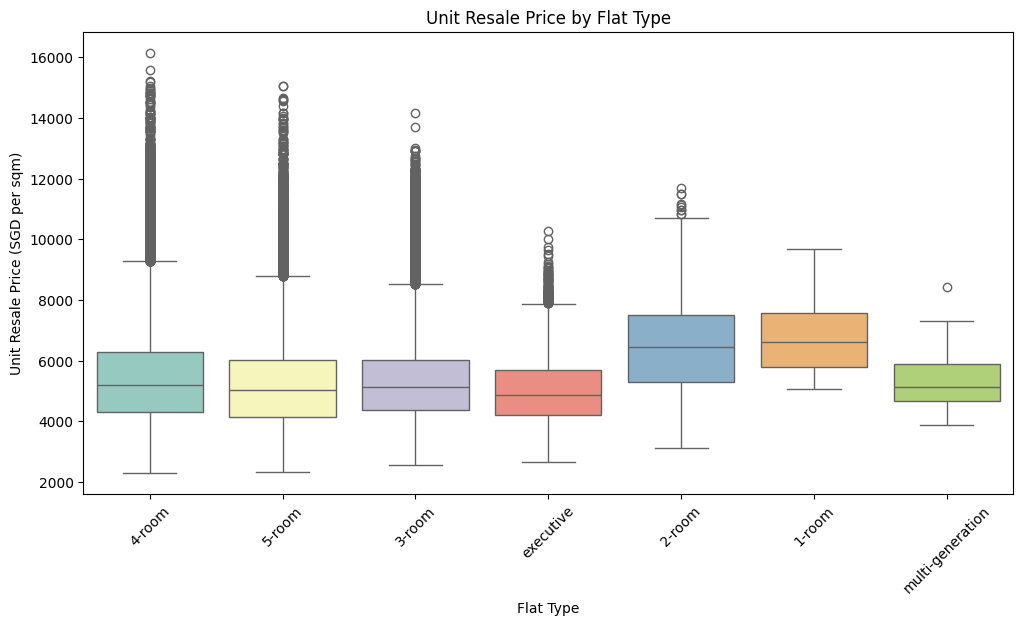

/tmp/ipython-input-1641379615.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


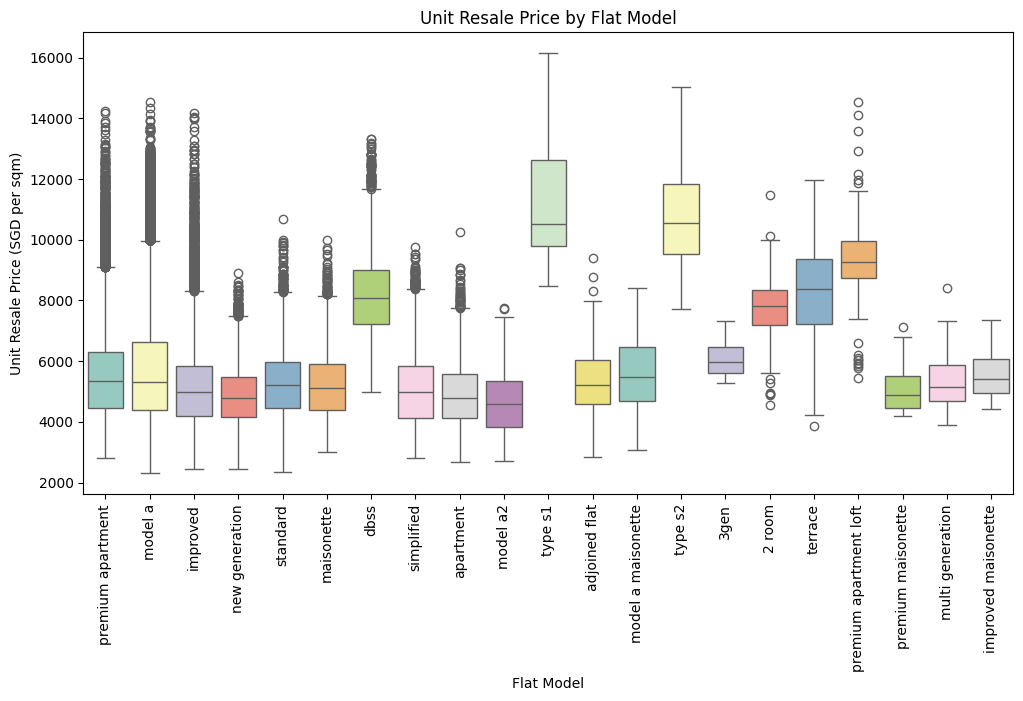

In [ ]:
# FLAT_TYPE
# FLAT_MODEL

plt.figure(figsize=(12,6))
sns.boxplot(
    x='FLAT_TYPE',
    y='resale_price_per_sqm',
    data=df_train,
    palette='Set3'
)
plt.title('Unit Resale Price by Flat Type')
plt.xlabel('Flat Type')
plt.ylabel('Unit Resale Price (SGD per sqm)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(
    x='FLAT_MODEL',
    y='resale_price_per_sqm',
    data=df_train,
    palette='Set3'
)
plt.title('Unit Resale Price by Flat Model')
plt.xlabel('Flat Model')
plt.ylabel('Unit Resale Price (SGD per sqm)')
plt.xticks(rotation=90)
plt.show()

### one hot encoding (helper function)

In [ ]:
# to be used for data preprocessing later on

def one_hot_encode(df, columns, drop_original=True):
    """
    One-hot encode categorical columns with 0/1 encoding.

    Parameters:
    - df: pandas DataFrame
    - columns: list of column names to encode
    - drop_original: if True, drops the original columns

    Returns:
    - df: DataFrame with one-hot encoded columns (values as 0 and 1)
    """
    for col in columns:
        # Get one-hot encoded columns, explicitly as int
        dummies = pd.get_dummies(df[col], prefix=col).astype(int)

        # Concatenate the new columns
        df = pd.concat([df, dummies], axis=1)

        # Drop original column if requested
        if drop_original:
            df = df.drop(columns=[col])

    return df

In [ ]:
df_train = one_hot_encode(df_train, ['FLAT_TYPE', 'FLAT_MODEL'])
df_train.head()

,MONTH,TOWN,BLOCK,STREET,FLOOR_RANGE,FLOOR_AREA_SQM,ECO_CATEGORY,LEASE_COMMENCE_DATA,RESALE_PRICE,resale_price_per_sqm,...,FLAT_MODEL_multi generation,FLAT_MODEL_new generation,FLAT_MODEL_premium apartment,FLAT_MODEL_premium apartment loft,FLAT_MODEL_premium maisonette,FLAT_MODEL_simplified,FLAT_MODEL_standard,FLAT_MODEL_terrace,FLAT_MODEL_type s1,FLAT_MODEL_type s2
0,2020-10,woodlands,681B,woodlands drive 62,07 to 09,102.0,uncategorized,2000,420000.0,4117.647059,...,0,0,1,0,0,0,0,0,0,0
1,2021-07,bishan,264,bishan street 24,07 to 09,104.0,uncategorized,1992,585000.0,5625.000000,...,0,0,0,0,0,0,0,0,0,0
2,2021-05,bukit panjang,520,jelapang road,19 to 21,102.0,uncategorized,1998,450000.0,4411.764706,...,0,0,0,0,0,0,0,0,0,0
3,2021-08,punggol,121B,edgedale plains,16 to 18,93.0,uncategorized,2017,465000.0,5000.000000,...,0,0,0,0,0,0,0,0,0,0
4,2023-05,hougang,997B,Buangkok Crescent,10 to 12,113.0,uncategorized,2018,710000.0,6283.185841,...,0,0,0,0,0,0,0,0,0,0


## Location features (subzone/town/planning area/region)

### Merging with HDB details dataset

In [ ]:
# Matching the column names for both dataset and setting all entry to lower case
df_hdb_details = df_hdb_details.rename(columns={"ADDRESS": "STREET"})

df_train["STREET"] = df_train["STREET"].str.lower()
df_hdb_details["STREET"] = df_hdb_details["STREET"].str.lower()

print(df_train.columns)
print(df_hdb_details.columns)

print(df_train.shape)
print(df_hdb_details.shape)

Index(['MONTH', 'TOWN', 'BLOCK', 'STREET', 'FLOOR_RANGE', 'FLOOR_AREA_SQM',
       'ECO_CATEGORY', 'LEASE_COMMENCE_DATA', 'RESALE_PRICE',
       'resale_price_per_sqm', 'date', 'year', 'month_num',
       'months_since_start', 'flat_age', 'remaining_lease', 'short_lease_flag',
       'log_remaining_lease', 'FLAT_TYPE_1-room', 'FLAT_TYPE_2-room',
       'FLAT_TYPE_3-room', 'FLAT_TYPE_4-room', 'FLAT_TYPE_5-room',
       'FLAT_TYPE_executive', 'FLAT_TYPE_multi-generation',
       'FLAT_MODEL_2 room', 'FLAT_MODEL_3gen', 'FLAT_MODEL_adjoined flat',
       'FLAT_MODEL_apartment', 'FLAT_MODEL_dbss', 'FLAT_MODEL_improved',
       'FLAT_MODEL_improved maisonette', 'FLAT_MODEL_maisonette',
       'FLAT_MODEL_model a', 'FLAT_MODEL_model a maisonette',
       'FLAT_MODEL_model a2', 'FLAT_MODEL_multi generation',
       'FLAT_MODEL_new generation', 'FLAT_MODEL_premium apartment',
       'FLAT_MODEL_premium apartment loft', 'FLAT_MODEL_premium maisonette',
       'FLAT_MODEL_simplified', 'FLAT_MODEL

In [ ]:
# check if set of block-street pairs in df_train is a subset of that in df_hdb_details
block_street_pairs1 = df_train[["BLOCK", "STREET"]].drop_duplicates()
block_street_pairs2 = df_hdb_details[["BLOCK", "STREET"]].drop_duplicates()

set1 = set(map(tuple, block_street_pairs1.to_numpy()))
set2 = set(map(tuple, block_street_pairs2.to_numpy()))

print("df_train is a subset of that in df_hdb_details:", set1.issubset(set2))

df_train is a subset of that in df_hdb_details: True


In [ ]:
# Merge df_hdb_details into df_train
cols_to_keep = ["POSTAL_CODE","LATITUDE","LONGITUDE","MAX_FLOOR","SUBZONE","PLANNING_AREA","REGION"]
train_cols_before = len(df_train)

df_train_with_HDB_coordinates = df_train.merge(
    df_hdb_details[["BLOCK","STREET"] + cols_to_keep],
    on=["BLOCK","STREET"], how="left"
)

print("Rows before:", train_cols_before, "Rows after:", len(df_train_with_HDB_coordinates))
print("Missing LAT/LON after merge:", df_train_with_HDB_coordinates["LATITUDE"].isna().mean())

df_train_with_HDB_coordinates.head()

Rows before: 162570 Rows after: 162570
Missing LAT/LON after merge: 0.0


,MONTH,TOWN,BLOCK,STREET,FLOOR_RANGE,FLOOR_AREA_SQM,ECO_CATEGORY,LEASE_COMMENCE_DATA,RESALE_PRICE,resale_price_per_sqm,...,FLAT_MODEL_terrace,FLAT_MODEL_type s1,FLAT_MODEL_type s2,POSTAL_CODE,LATITUDE,LONGITUDE,MAX_FLOOR,SUBZONE,PLANNING_AREA,REGION
0,2020-10,woodlands,681B,woodlands drive 62,07 to 09,102.0,uncategorized,2000,420000.0,4117.647059,...,0,0,0,732681,1.439325,103.803324,14,woodlands east,woodlands,north region
1,2021-07,bishan,264,bishan street 24,07 to 09,104.0,uncategorized,1992,585000.0,5625.000000,...,0,0,0,570264,1.358659,103.842050,16,marymount,bishan,central region
2,2021-05,bukit panjang,520,jelapang road,19 to 21,102.0,uncategorized,1998,450000.0,4411.764706,...,0,0,0,670520,1.386468,103.766508,20,saujana,bukit panjang,west region
3,2021-08,punggol,121B,edgedale plains,16 to 18,93.0,uncategorized,2017,465000.0,5000.000000,...,0,0,0,822121,1.393089,103.909042,17,punggol field,punggol,north-east region
4,2023-05,hougang,997B,buangkok crescent,10 to 12,113.0,uncategorized,2018,710000.0,6283.185841,...,0,0,0,532997,1.385902,103.881387,16,trafalgar,hougang,north-east region


In [ ]:
print(df_train_with_HDB_coordinates.columns)

Index(['MONTH', 'TOWN', 'BLOCK', 'STREET', 'FLOOR_RANGE', 'FLOOR_AREA_SQM',
       'ECO_CATEGORY', 'LEASE_COMMENCE_DATA', 'RESALE_PRICE',
       'resale_price_per_sqm', 'date', 'year', 'month_num',
       'months_since_start', 'flat_age', 'remaining_lease', 'short_lease_flag',
       'log_remaining_lease', 'FLAT_TYPE_1-room', 'FLAT_TYPE_2-room',
       'FLAT_TYPE_3-room', 'FLAT_TYPE_4-room', 'FLAT_TYPE_5-room',
       'FLAT_TYPE_executive', 'FLAT_TYPE_multi-generation',
       'FLAT_MODEL_2 room', 'FLAT_MODEL_3gen', 'FLAT_MODEL_adjoined flat',
       'FLAT_MODEL_apartment', 'FLAT_MODEL_dbss', 'FLAT_MODEL_improved',
       'FLAT_MODEL_improved maisonette', 'FLAT_MODEL_maisonette',
       'FLAT_MODEL_model a', 'FLAT_MODEL_model a maisonette',
       'FLAT_MODEL_model a2', 'FLAT_MODEL_multi generation',
       'FLAT_MODEL_new generation', 'FLAT_MODEL_premium apartment',
       'FLAT_MODEL_premium apartment loft', 'FLAT_MODEL_premium maisonette',
       'FLAT_MODEL_simplified', 'FLAT_MODEL

### Analysis of location features

In [ ]:
cols = ["REGION", "PLANNING_AREA", "TOWN", "SUBZONE"]

for col in cols:
  print("=======================================")
  print(f"Number of unique {col}s:", df_train_with_HDB_coordinates[col].nunique())
  print(f"Unique {col}s:", df_train_with_HDB_coordinates[col].unique())

Number of unique REGIONs: 5
Unique REGIONs: ['north region' 'central region' 'west region' 'north-east region'
 'east region']
Number of unique PLANNING_AREAs: 31
Unique PLANNING_AREAs: ['woodlands' 'bishan' 'bukit panjang' 'punggol' 'hougang' 'clementi'
 'bedok' 'yishun' 'sengkang' 'queenstown' 'bukit batok' 'pasir ris'
 'toa payoh' 'geylang' 'tampines' 'bukit merah' 'ang mo kio' 'sembawang'
 'choa chu kang' 'jurong west' 'novena' 'kallang' 'serangoon' 'outram'
 'jurong east' 'marine parade' 'bukit timah' 'rochor' 'tanglin'
 'downtown core' 'changi']
Number of unique TOWNs: 26
Unique TOWNs: ['woodlands' 'bishan' 'bukit panjang' 'punggol' 'hougang' 'clementi'
 'bedok' 'yishun' 'sengkang' 'queenstown' 'bukit batok' 'pasir ris'
 'toa payoh' 'geylang' 'tampines' 'bukit merah' 'ang mo kio' 'sembawang'
 'choa chu kang' 'jurong west' 'kallang/whampoa' 'serangoon'
 'central area' 'jurong east' 'marine parade' 'bukit timah']
Number of unique SUBZONEs: 156
Unique SUBZONEs: ['woodlands east' 'ma

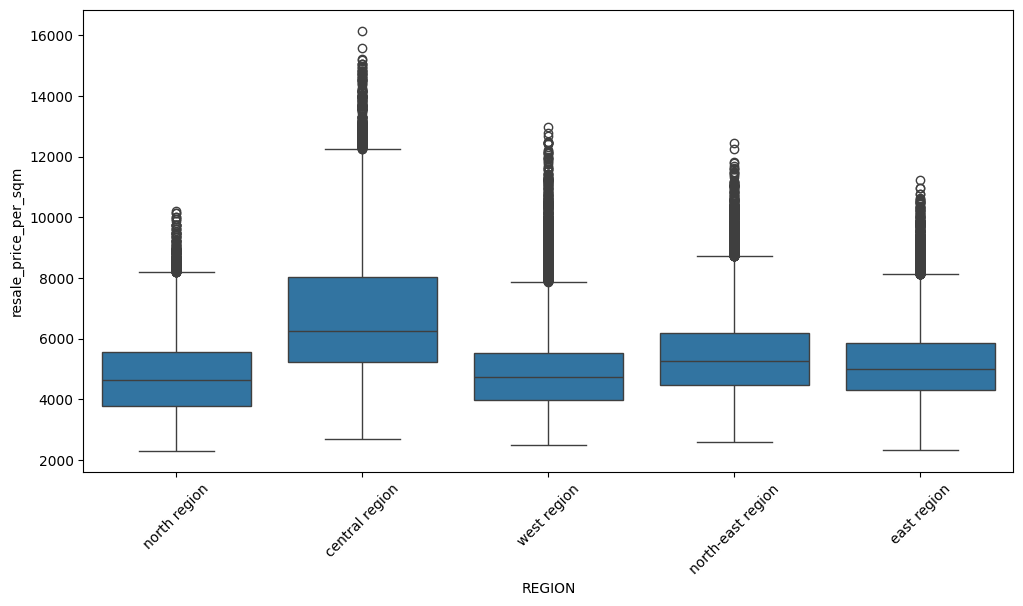

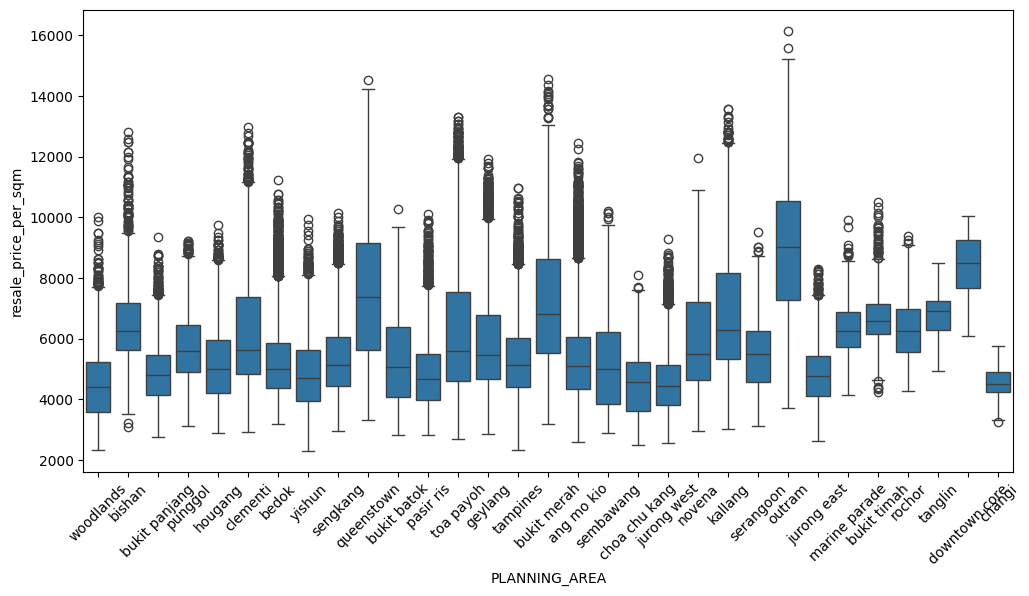

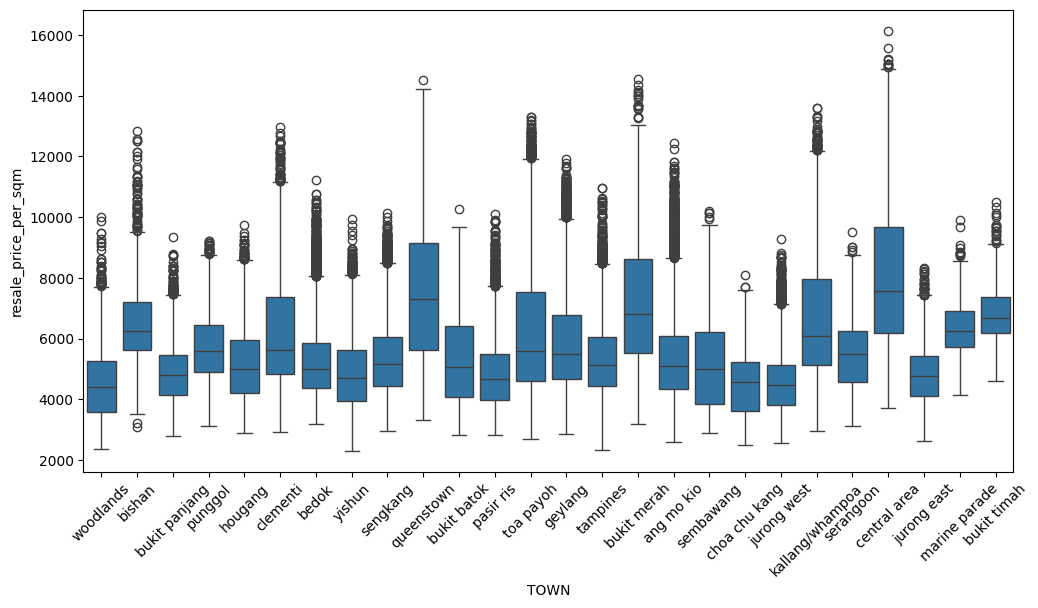

In [ ]:
# Check prices based on region -> planning area -> town -> subzone (based on size)
for col in cols:
  if col == "SUBZONE":
    continue
  plt.figure(figsize=(12, 6))
  sns.boxplot(data=df_train_with_HDB_coordinates, x=col, y="resale_price_per_sqm")
  plt.xticks(rotation=45)
  plt.show()

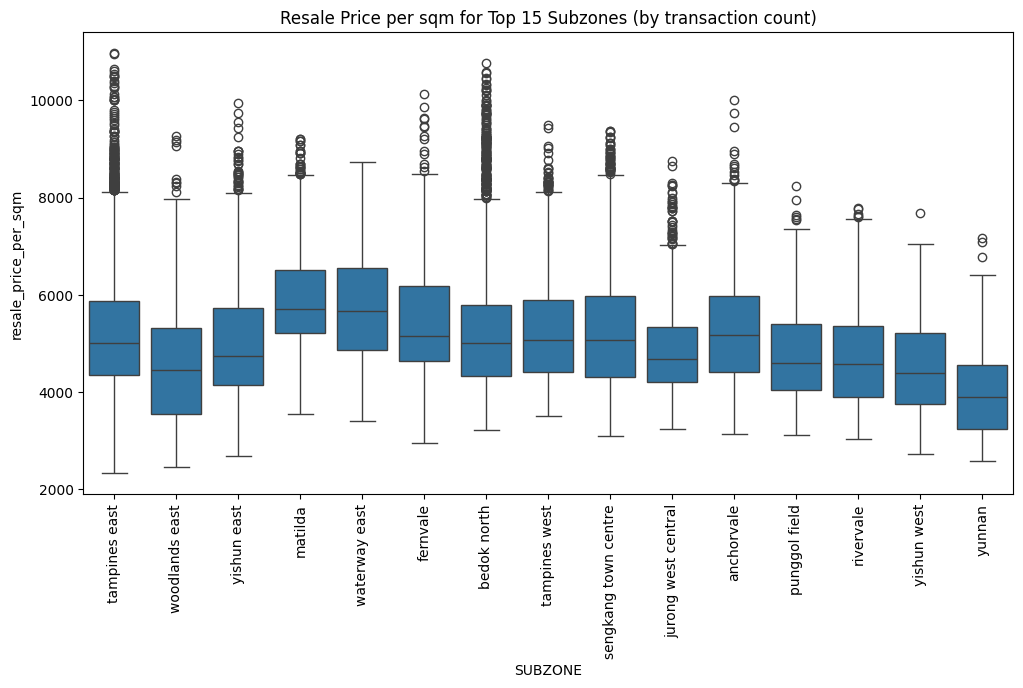

In [ ]:
top_subzones = (
    df_train_with_HDB_coordinates["SUBZONE"]
    .value_counts()
    .head(15)
    .index
)

df_top_subzones = df_train_with_HDB_coordinates[df_train_with_HDB_coordinates["SUBZONE"].isin(top_subzones)]

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_top_subzones,
    x="SUBZONE",
    y="resale_price_per_sqm",
    order=top_subzones
)
plt.xticks(rotation=90)
plt.title("Resale Price per sqm for Top 15 Subzones (by transaction count)")
plt.show()

In [ ]:
# statistics on number of hdb transactions in a region/planning area/town/subzone
for col in cols:
  print(col)
  print(df_train_with_HDB_coordinates[col].value_counts().describe())

REGION
count        5.000000
mean     32514.000000
std       7634.338707
min      24210.000000
25%      27489.000000
50%      30292.000000
75%      37733.000000
max      42846.000000
Name: count, dtype: float64
PLANNING_AREA
count       31.000000
mean      5244.193548
std       4000.497064
min         24.000000
25%       2069.000000
50%       4702.000000
75%       7753.000000
max      13320.000000
Name: count, dtype: float64
TOWN
count       26.000000
mean      6252.692308
std       3618.939820
min        401.000000
25%       3695.000000
50%       5528.500000
75%       8366.750000
max      13320.000000
Name: count, dtype: float64
SUBZONE
count     156.000000
mean     1042.115385
std       996.706706
min        13.000000
25%       399.250000
50%       750.500000
75%      1354.000000
max      6050.000000
Name: count, dtype: float64


<Axes: xlabel='resale_price_per_sqm', ylabel='Density'>

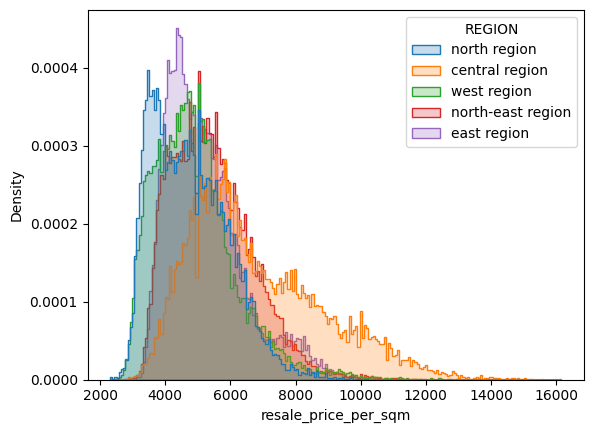

In [ ]:
# show probability density of a hdb (with said resale_price_per_sqm) being part of that region)
sns.histplot(data=df_train_with_HDB_coordinates, x="resale_price_per_sqm", hue="REGION", element="step", stat="density", common_norm=False)

### target encoding (helper function)

In [ ]:
def target_encode(df, columns, target, drop_original=False):

    df = df.copy()
    for col in columns:
        means = df.groupby(col)[target].mean()
        # Map category to mean value
        df[f"{col}_TE"] = df[col].map(means)

        if drop_original:
            df = df.drop(col, axis=1)
    return df

In [ ]:
df_train_with_HDB_coordinates = target_encode(
    df_train_with_HDB_coordinates,
    ['PLANNING_AREA', 'TOWN'],
    'resale_price_per_sqm'
)

In [ ]:
# one hot encode for region
df_train_with_HDB_coordinates = one_hot_encode(df_train_with_HDB_coordinates, ['REGION'])

In [ ]:
df_train_with_HDB_coordinates.head()

,MONTH,TOWN,BLOCK,STREET,FLOOR_RANGE,FLOOR_AREA_SQM,ECO_CATEGORY,LEASE_COMMENCE_DATA,RESALE_PRICE,resale_price_per_sqm,...,MAX_FLOOR,SUBZONE,PLANNING_AREA,PLANNING_AREA_TE,TOWN_TE,REGION_central region,REGION_east region,REGION_north region,REGION_north-east region,REGION_west region
0,2020-10,woodlands,681B,woodlands drive 62,07 to 09,102.0,uncategorized,2000,420000.0,4117.647059,...,14,woodlands east,woodlands,4513.172609,4513.172609,0,0,1,0,0
1,2021-07,bishan,264,bishan street 24,07 to 09,104.0,uncategorized,1992,585000.0,5625.000000,...,16,marymount,bishan,6483.349121,6483.349121,1,0,0,0,0
2,2021-05,bukit panjang,520,jelapang road,19 to 21,102.0,uncategorized,1998,450000.0,4411.764706,...,20,saujana,bukit panjang,4872.035338,4872.035338,0,0,0,0,1
3,2021-08,punggol,121B,edgedale plains,16 to 18,93.0,uncategorized,2017,465000.0,5000.000000,...,17,punggol field,punggol,5672.726419,5672.726419,0,0,0,1,0
4,2023-05,hougang,997B,buangkok crescent,10 to 12,113.0,uncategorized,2018,710000.0,6283.185841,...,16,trafalgar,hougang,5181.523244,5181.523244,0,0,0,1,0


## Floor feature - low floor VS mid floor VS high floor

In [ ]:
# Helper Functions
def categorize_floor(row):
    floor_range = row["FLOOR_RANGE"]
    max_floor = row["MAX_FLOOR"]

    if 'to' in str(floor_range):
        lower_bound = int(str(floor_range).split(' to ')[0])
    else:
        try:
            lower_bound = int(str(floor_range).split()[0])
        except:
            return 'unknown'

    if pd.notna(max_floor):
        if lower_bound <= max_floor * 0.33:
            return "low"
        elif lower_bound <= max_floor * 0.66:
            return "mid"
        else:
            return "high"
    return None

In [ ]:
df_train_with_HDB_coordinates["floor_category"] = df_train_with_HDB_coordinates.apply(categorize_floor, axis=1)


,MONTH,TOWN,BLOCK,STREET,FLOOR_RANGE,FLOOR_AREA_SQM,ECO_CATEGORY,LEASE_COMMENCE_DATA,RESALE_PRICE,resale_price_per_sqm,date,year,month_num,months_since_start,flat_age,remaining_lease,short_lease_flag,log_remaining_lease,FLAT_TYPE_1-room,FLAT_TYPE_2-room,FLAT_TYPE_3-room,FLAT_TYPE_4-room,FLAT_TYPE_5-room,FLAT_TYPE_executive,FLAT_TYPE_multi-generation,FLAT_MODEL_2 room,FLAT_MODEL_3gen,FLAT_MODEL_adjoined flat,FLAT_MODEL_apartment,FLAT_MODEL_dbss,FLAT_MODEL_improved,FLAT_MODEL_improved maisonette,FLAT_MODEL_maisonette,FLAT_MODEL_model a,FLAT_MODEL_model a maisonette,FLAT_MODEL_model a2,FLAT_MODEL_multi generation,FLAT_MODEL_new generation,FLAT_MODEL_premium apartment,FLAT_MODEL_premium apartment loft,FLAT_MODEL_premium maisonette,FLAT_MODEL_simplified,FLAT_MODEL_standard,FLAT_MODEL_terrace,FLAT_MODEL_type s1,FLAT_MODEL_type s2,POSTAL_CODE,LATITUDE,LONGITUDE,MAX_FLOOR,SUBZONE,PLANNING_AREA,PLANNING_AREA_TE,TOWN_TE,REGION_central region,REGION_east region,REGION_north region,REGION_north-east region,REGION_west region,floor_category_high,floor_category_low,floor_category_mid
0,2020-10,woodlands,681B,woodlands drive 62,07 to 09,102.0,uncategorized,2000,420000.0,4117.647059,2020-10-01,2020,10,46,20,79,0,4.382027,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,732681,1.439325,103.803324,14,woodlands east,woodlands,4513.172609,4513.172609,0,0,1,0,0,0,0,1
1,2021-07,bishan,264,bishan street 24,07 to 09,104.0,uncategorized,1992,585000.0,5625.000000,2021-07-01,2021,7,55,29,70,0,4.262680,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,570264,1.358659,103.842050,16,marymount,bishan,6483.349121,6483.349121,1,0,0,0,0,0,0,1
2,2021-05,bukit panjang,520,jelapang road,19 to 21,102.0,uncategorized,1998,450000.0,4411.764706,2021-05-01,2021,5,53,23,76,0,4.343805,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,670520,1.386468,103.766508,20,saujana,bukit panjang,4872.035338,4872.035338,0,0,0,0,1,1,0,0
3,2021-08,punggol,121B,edgedale plains,16 to 18,93.0,uncategorized,2017,465000.0,5000.000000,2021-08-01,2021,8,56,4,95,0,4.564348,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,822121,1.393089,103.909042,17,punggol field,punggol,5672.726419,5672.726419,0,0,0,1,0,1,0,0
4,2023-05,hougang,997B,buangkok crescent,10 to 12,113.0,uncategorized,2018,710000.0,6283.185841,2023-05-01,2023,5,77,5,94,0,4.553877,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,532997,1.385902,103.881387,16,trafalgar,hougang,5181.523244,5181.523244,0,0,0,1,0,0,0,1


Unit Price Statistics by Floor Category:
                count     mean   median      std      min       max
floor_category                                                     
high            48995  5632.63  5333.33  1662.15  2448.98  16148.94
low             53150  5200.52  4950.50  1469.82  2307.69  14481.72
mid             60425  5418.52  5144.44  1566.78  2372.88  14838.71


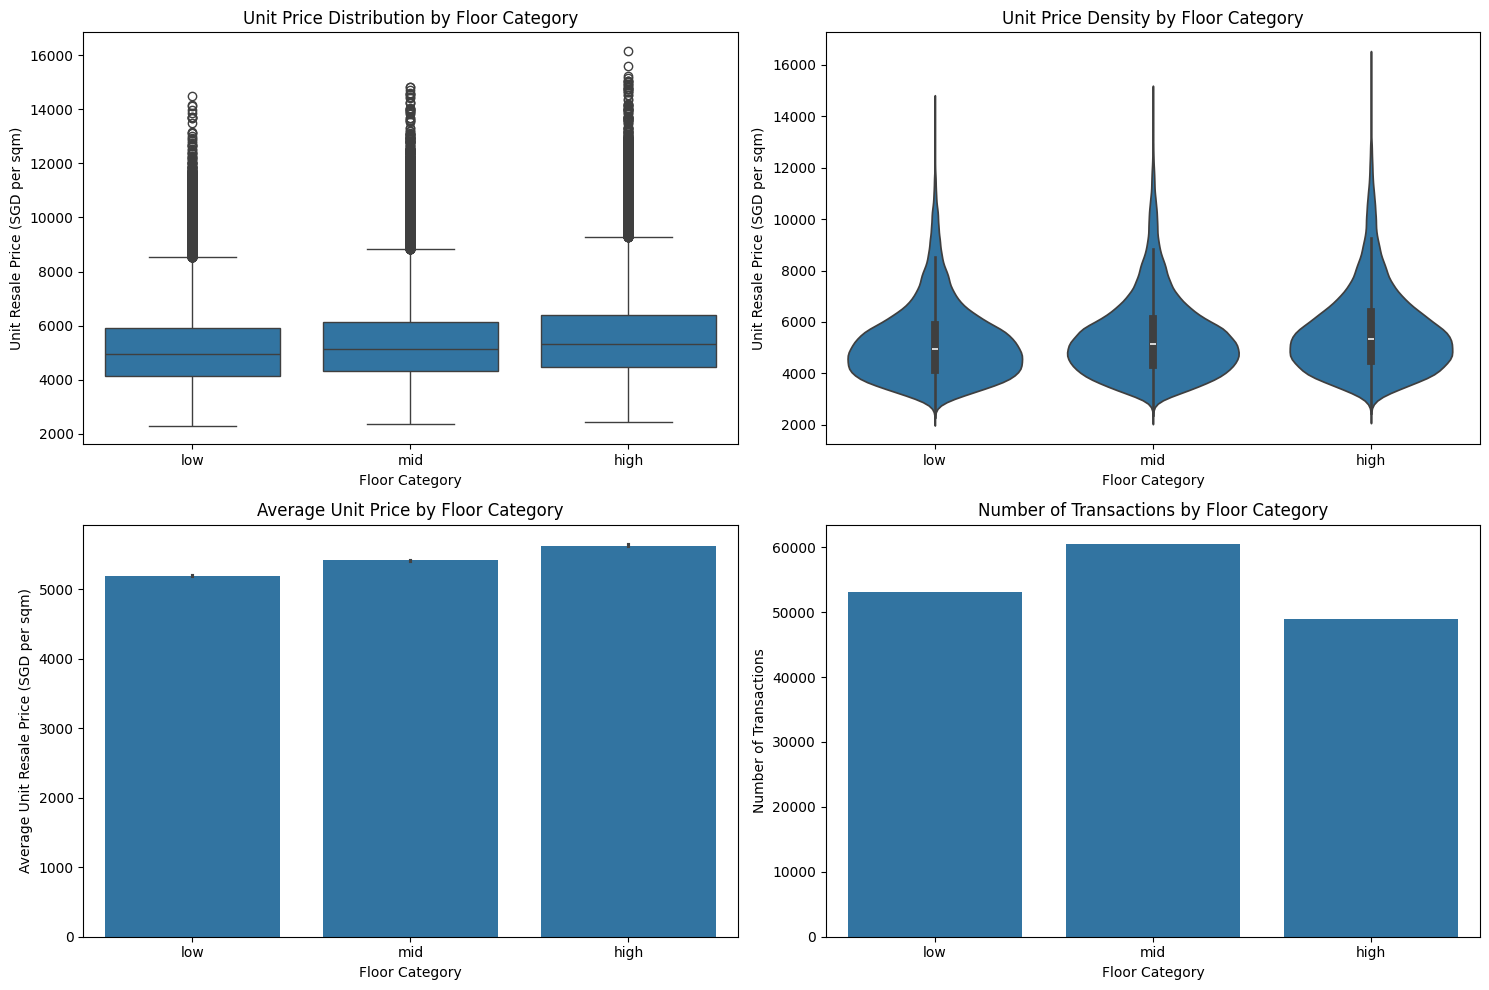

In [ ]:
# Basic statistical analysis by floor category
print("Unit Price Statistics by Floor Category:")
floor_price_stats = df_train_with_HDB_coordinates.groupby('floor_category')['resale_price_per_sqm'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)
print(floor_price_stats)

# Visualize the relationship
plt.figure(figsize=(15, 10))

# Box plot
plt.subplot(2, 2, 1)
sns.boxplot(x='floor_category', y='resale_price_per_sqm', data=df_train_with_HDB_coordinates,
            order=['low', 'mid', 'high'])
plt.title('Unit Price Distribution by Floor Category')
plt.xlabel('Floor Category')
plt.ylabel('Unit Resale Price (SGD per sqm)')


# Bar plot with confidence intervals
plt.subplot(2, 2, 3)
sns.barplot(x='floor_category', y='resale_price_per_sqm', data=df_train_with_HDB_coordinates,
            order=['low', 'mid', 'high'])
plt.title('Average Unit Price by Floor Category')
plt.xlabel('Floor Category')
plt.ylabel('Average Unit Resale Price (SGD per sqm)')

# Count plot to show data distribution
plt.subplot(2, 2, 4)
sns.countplot(x='floor_category', data=df_train_with_HDB_coordinates, order=['low', 'mid', 'high'])
plt.title('Number of Transactions by Floor Category')
plt.xlabel('Floor Category')
plt.ylabel('Number of Transactions')

plt.tight_layout()
plt.show()

In [ ]:
df_train_with_HDB_coordinates = one_hot_encode(df_train_with_HDB_coordinates, ['floor_category'])
df_train_with_HDB_coordinates.head()

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='MAX_FLOOR', y='resale_price_per_sqm', data=df_train_with_HDB_coordinates)
plt.title('Unit Price Distribution by Max Floor')
plt.xlabel('Max Floor')
plt.ylabel('Unit Resale Price (SGD per sqm)')

# EDA: Additional locational features

### Helper functions

In [ ]:
# imports
from sklearn.metrics.pairwise import haversine_distances
import numpy as np
from sklearn.neighbors import BallTree
import time
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_distance(lat1, long1, lat2, long2):
    """
    Calculate great-circle distance between two geographic points.

    Args:
        lat1 (float): Latitude of the first point in decimal degrees
        long1 (float): Longitude of the first point in decimal degrees
        lat2 (float): Latitude of the second point in decimal degrees
        long2 (float): Longitude of the second point in decimal degrees

    Returns:
        float: Distance between the two points in kilometers
    """
    point1_rad = np.radians([lat1, long1])
    point2_rad = np.radians([lat2, long2])

    distance_radians = haversine_distances([point1_rad], [point2_rad])[0, 0]
    R_km = 6371
    distance_km = distance_radians * R_km
    return distance_km

def _count_codes(indices):
    seen = set()
    for i in indices:
        for c in codes_arr[i].split(","):
            c = c.strip()
            if c:
                seen.add(c)
    return len(seen)

def nearest_mrt_distance(latitude, longitude, tree, earth_radius_km=6371.0):
    """
    Find distance to the nearest MRT station.

    Args:
        latitude (float): Latitude of the location in decimal degrees
        longitude (float): Longitude of the location in decimal degrees
        tree: Pre-built spatial tree of MRT station coordinates in radians
        earth_radius_km (float): Radius of the Earth in kilometers (default = 6371)

    Returns:
        float: Distance to the closest MRT station in kilometers
    """
    dist_rad, _ = tree.query(np.radians([[latitude, longitude]]), k=1)
    return float(dist_rad[0, 0] * earth_radius_km)

def add_location_features(hdb_df, auxiliary_df, name):
    """
    Add nearest and radius-based location features for HDBs df based on auxiliary data.

    Parameters:
    - hdb_df: flats dataframe (with LATITUDE, LONGITUDE columns)
    - auxiliary_df: dataframe of HDBs (with LATITUDE, LONGITUDE, NAME columns)
    - name: prefix for feature columns (e.g., 'mall', 'pri_sch', 'sec_sch')
    """

    # Build BallTree on auxiliary data
    rad = np.radians(auxiliary_df[["LATITUDE", "LONGITUDE"]].to_numpy(dtype=float))
    tree = BallTree(rad, metric="haversine")

    # Query nearest auxiliary service/place for each flat
    pts_rad = np.radians(hdb_df[["LATITUDE", "LONGITUDE"]].to_numpy(dtype=float))
    dist_rad, idx = tree.query(pts_rad, k=1)
    nearest_idx = idx.ravel()

    df = hdb_df.copy()
    R_KM = 6371.0
    df[f"nearest_{name}_distance_km"] = dist_rad.ravel() * R_KM
    df[f"nearest_{name}_name"] = auxiliary_df.iloc[nearest_idx]["NAME"].to_numpy()

    # Walkability + counts
    idx_lists_1km  = tree.query_radius(pts_rad, r=1.0 / R_KM)
    idx_lists_05km = tree.query_radius(pts_rad, r=0.5 / R_KM)

    df[f"{name}_within_1km"]   = [len(ix) > 0 for ix in idx_lists_1km]
    df[f"{name}_within_0.5km"] = [len(ix) > 0 for ix in idx_lists_05km]
    df[f"{name}_count_within_1km"]   = [len(ix) for ix in idx_lists_1km]
    df[f"{name}_count_within_0.5km"] = [len(ix) for ix in idx_lists_05km]

    return df

def analyse_features(df, aux_name, price_col="RESALE_PRICE", bins=15):
    """
    Analyse auxiliary-based location features against resale price.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe with HDB + auxiliary features
    aux_name : str
        Prefix for auxiliary columns (e.g., 'mall', 'hawker', 'pri_sch')
    price_col : str, default 'RESALE_PRICE'
        Column name for resale price
    bins : int, default 15
        Number of bins for histograms
    """

    # Copy to avoid modifying original
    df = df.copy()

    # Column names based on prefix
    dist_col = f"nearest_{aux_name}_distance_km"
    cnt_col  = f"{aux_name}_count_within_1km"
    bin_cols = [f"{aux_name}_within_1km", f"{aux_name}_within_0.5km"]

    # --- Distribution plots ---
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[dist_col])
    plt.title(f"Boxplot of {dist_col}")
    plt.show()

    df.hist(column=dist_col, bins=bins, edgecolor="black", figsize=(6,4))
    plt.suptitle(f"Histogram of {dist_col}")
    plt.show()

    # --- Correlations ---
    corr_dist = df[[dist_col, price_col]].corr(method="spearman").loc[dist_col, price_col]
    corr_cnt  = df[[cnt_col, price_col]].corr(method="spearman").loc[cnt_col, price_col]

    # Cast binary cols to int
    for col in bin_cols:
        df[col] = df[col].astype(int)

    corrs = {col: df[[col, price_col]].corr(method="spearman").loc[col, price_col] for col in bin_cols}

    print(f"Spearman({dist_col}, {price_col}) = {corr_dist:.4f}")
    print(f"Spearman({cnt_col}, {price_col})  = {corr_cnt:.4f}")
    for col, val in corrs.items():
        print(f"Spearman({col}, {price_col}) = {val:.4f}")

    # --- Scatter plot with regression ---
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=df, x=dist_col, y=price_col, alpha=0.3, s=10)
    sns.regplot(data=df, x=dist_col, y=price_col, scatter=False, color="red", lowess=True)
    plt.title(f"{price_col} vs {dist_col}")
    plt.tight_layout()
    plt.show()

    # --- Boxplots for binary features ---
    for col in bin_cols:
        plt.figure(figsize=(6,5))
        sns.boxplot(data=df, x=col, y=price_col)
        plt.title(f"{price_col} Distribution by {col}")
        plt.tight_layout()
        plt.show()

    # --- Boxplot for count feature ---
    plt.figure(figsize=(7,5))
    sns.boxplot(data=df, x=cnt_col, y=price_col)
    plt.title(f"{price_col} Distribution by {cnt_col}")
    plt.tight_layout()
    plt.show()

## MRT data

### Merging dataset with MRT info / generating features

In [ ]:
# Building df_train_with_HDB_MRT_info
# As there are stations with the same name but different code and status, grouping them together and keep the best status code
status_order = {"open": 1, "planned": 0}
mrt = df_mrt_stations.copy()
mrt["status_rank"] = mrt["STATUS"].str.lower().map(status_order).fillna(9).astype(int)

mrt_dedup = (
    mrt.sort_values("status_rank")
       .groupby(["NAME", "LATITUDE", "LONGITUDE"], as_index=False)
       .agg({
           "status_rank": "first",
           "STATUS": "first",
           "CODE": lambda s: ",".join(sorted(set(map(str, s))))
       })
       .rename(columns={"STATUS": "BEST_STATUS", "CODE": "CODES"})
)

# Build BallTree on deduplicated stations
mrt_rad = np.radians(mrt_dedup[["LATITUDE", "LONGITUDE"]].to_numpy(dtype=float))
tree = BallTree(mrt_rad, metric="haversine")

# Query nearest station for every row; record distance (km), name, status, and codes
pts_rad = np.radians(df_train_with_HDB_coordinates[["LATITUDE", "LONGITUDE"]].to_numpy(dtype=float))
dist_rad, idx = tree.query(pts_rad, k=1)
dist_km = dist_rad.flatten() * 6371.0
nearest_idx = idx.flatten()

df_train_with_HDB_MRT_info = df_train_with_HDB_coordinates.copy()

df_train_with_HDB_MRT_info["nearest_mrt_distance_km"] = dist_km
df_train_with_HDB_MRT_info["nearest_mrt_name"] = mrt_dedup.iloc[nearest_idx]["NAME"].to_numpy()
df_train_with_HDB_MRT_info["nearest_mrt_status"] = mrt_dedup.iloc[nearest_idx]["BEST_STATUS"].to_numpy()
df_train_with_HDB_MRT_info["nearest_mrt_codes"] = mrt_dedup.iloc[nearest_idx]["CODES"].to_numpy()

# Count distinct MRT codes within 1 km for each flat (using the same BallTree)
R_KM = 6371.0
idx_lists = tree.query_radius(pts_rad, r=1.0 / R_KM)  # neighbors within 1 km (radians)
codes_arr = mrt_dedup["CODES"].to_numpy()
df_train_with_HDB_MRT_info["mrt_code_count_within_1km"] = [ _count_codes(idxs) for idxs in idx_lists ]

df_train_with_HDB_MRT_info.head()

,MONTH,TOWN,BLOCK,STREET,FLOOR_RANGE,FLOOR_AREA_SQM,ECO_CATEGORY,LEASE_COMMENCE_DATA,RESALE_PRICE,resale_price_per_sqm,date,year,month_num,months_since_start,flat_age,remaining_lease,short_lease_flag,log_remaining_lease,FLAT_TYPE_1-room,FLAT_TYPE_2-room,FLAT_TYPE_3-room,FLAT_TYPE_4-room,FLAT_TYPE_5-room,FLAT_TYPE_executive,FLAT_TYPE_multi-generation,FLAT_MODEL_2 room,FLAT_MODEL_3gen,FLAT_MODEL_adjoined flat,FLAT_MODEL_apartment,FLAT_MODEL_dbss,FLAT_MODEL_improved,FLAT_MODEL_improved maisonette,FLAT_MODEL_maisonette,FLAT_MODEL_model a,FLAT_MODEL_model a maisonette,FLAT_MODEL_model a2,FLAT_MODEL_multi generation,FLAT_MODEL_new generation,FLAT_MODEL_premium apartment,FLAT_MODEL_premium apartment loft,FLAT_MODEL_premium maisonette,FLAT_MODEL_simplified,FLAT_MODEL_standard,FLAT_MODEL_terrace,FLAT_MODEL_type s1,FLAT_MODEL_type s2,POSTAL_CODE,LATITUDE,LONGITUDE,MAX_FLOOR,SUBZONE,PLANNING_AREA,PLANNING_AREA_TE,TOWN_TE,REGION_central region,REGION_east region,REGION_north region,REGION_north-east region,REGION_west region,floor_category_high,floor_category_low,floor_category_mid,nearest_mrt_distance_km,nearest_mrt_name,nearest_mrt_status,nearest_mrt_codes,mrt_code_count_within_1km
0,2020-10,woodlands,681B,woodlands drive 62,07 to 09,102.0,uncategorized,2000,420000.0,4117.647059,2020-10-01,2020,10,46,20,79,0,4.382027,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,732681,1.439325,103.803324,14,woodlands east,woodlands,4513.172609,4513.172609,0,0,1,0,0,0,0,1,0.306014,Admiralty MRT station,open,NS10,1
1,2021-07,bishan,264,bishan street 24,07 to 09,104.0,uncategorized,1992,585000.0,5625.000000,2021-07-01,2021,7,55,29,70,0,4.262680,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,570264,1.358659,103.842050,16,marymount,bishan,6483.349121,6483.349121,1,0,0,0,0,0,0,1,0.786298,Teck Ghee MRT station,planned,CR12,1
2,2021-05,bukit panjang,520,jelapang road,19 to 21,102.0,uncategorized,1998,450000.0,4411.764706,2021-05-01,2021,5,53,23,76,0,4.343805,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,670520,1.386468,103.766508,20,saujana,bukit panjang,4872.035338,4872.035338,0,0,0,0,1,1,0,0,1.052540,Bukit Panjang MRT/LRT station,open,"BP6,DT1",0
3,2021-08,punggol,121B,edgedale plains,16 to 18,93.0,uncategorized,2017,465000.0,5000.000000,2021-08-01,2021,8,56,4,95,0,4.564348,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,822121,1.393089,103.909042,17,punggol field,punggol,5672.726419,5672.726419,0,0,0,1,0,1,0,0,0.872296,Riviera MRT/LRT station,planned,"CP3,PE4",2
4,2023-05,hougang,997B,buangkok crescent,10 to 12,113.0,uncategorized,2018,710000.0,6283.185841,2023-05-01,2023,5,77,5,94,0,4.553877,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,532997,1.385902,103.881387,16,trafalgar,hougang,5181.523244,5181.523244,0,0,0,1,0,0,0,1,1.342862,Buangkok MRT station,open,NE15,0


### Analysis on derived features

array([[<Axes: title={'center': 'nearest_mrt_distance_km'}>]],
      dtype=object)

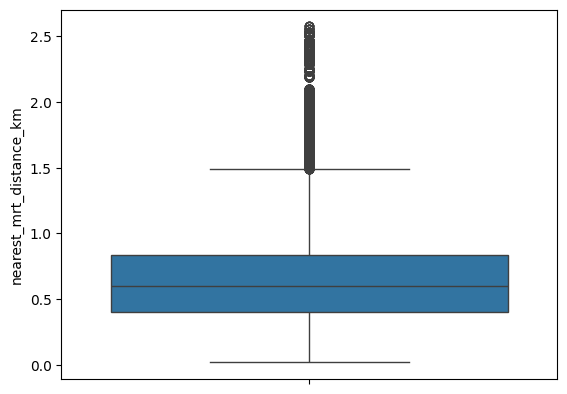

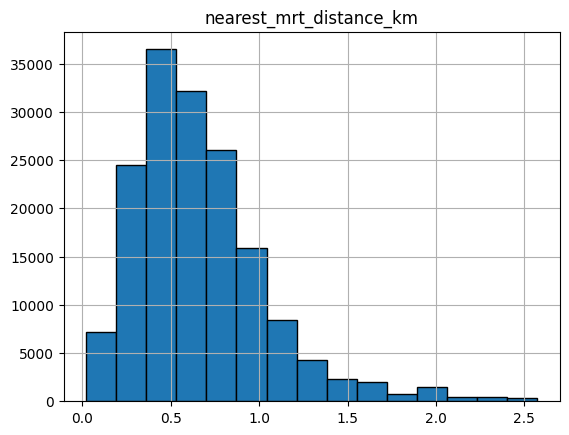

In [ ]:
sns.boxplot(df_train_with_HDB_MRT_info["nearest_mrt_distance_km"])

df_train_with_HDB_MRT_info.hist(column='nearest_mrt_distance_km', bins=15, edgecolor='black')

In [ ]:
# Add boolean walkability flags (True/False)
df_train_with_HDB_MRT_info["within_1km"]  = df_train_with_HDB_MRT_info["nearest_mrt_distance_km"] <= 1.0
df_train_with_HDB_MRT_info["within_0.5km"] = df_train_with_HDB_MRT_info["nearest_mrt_distance_km"] <= 0.5

# Boolean flag: station is an interchange (has multiple line codes)
df_train_with_HDB_MRT_info["has_interchange"] = (
    df_train_with_HDB_MRT_info["nearest_mrt_codes"].fillna("").str.contains(",")
)

In [ ]:
df = df_train_with_HDB_MRT_info.copy()

# Continuous features
corr_dist = df[['nearest_mrt_distance_km','RESALE_PRICE']].corr(method='spearman').loc['nearest_mrt_distance_km','RESALE_PRICE']
corr_codes = df[['mrt_code_count_within_1km','RESALE_PRICE']].corr(method='spearman').loc['mrt_code_count_within_1km','RESALE_PRICE']

# Binary features (cast to int for clarity)
df["within_1km"] = df["within_1km"].astype(int)
df["within_0.5km"] = df["within_0.5km"].astype(int)
df["has_interchange"] = df["has_interchange"].astype(int)
df["mrt_status_flag"] = (df["nearest_mrt_status"].str.lower() == "open").astype(int)

binary_cols = ["within_1km", "within_0.5km", "has_interchange", "mrt_status_flag"]
corrs = {col: df[[col,'RESALE_PRICE']].corr(method='spearman').loc[col,'RESALE_PRICE'] for col in binary_cols}

print(f"Spearman(nearest_mrt_distance_km, RESALE_PRICE) = {corr_dist:.4f}")
print(f"Spearman(mrt_code_count_within_1km, RESALE_PRICE) = {corr_codes:.4f}")
for col, val in corrs.items():
    print(f"Spearman({col}, RESALE_PRICE) = {val:.4f}")

print("===============================================")
corrs = {col: df[[col,'resale_price_per_sqm']].corr(method='spearman').loc[col,'resale_price_per_sqm'] for col in binary_cols}
print(f"Spearman(nearest_mrt_distance_km, RESALE_PRICE_PER_SQM) = {corr_dist:.4f}")
print(f"Spearman(mrt_code_count_within_1km, RESALE_PRICE_PER_SQM) = {corr_codes:.4f}")
for col, val in corrs.items():
    print(f"Spearman({col}, RESALE_PRICE_PER_SQM) = {val:.4f}")

Spearman(nearest_mrt_distance_km, RESALE_PRICE) = -0.1043
Spearman(mrt_code_count_within_1km, RESALE_PRICE) = 0.0775
Spearman(within_1km, RESALE_PRICE) = 0.0602
Spearman(within_0.5km, RESALE_PRICE) = 0.0918
Spearman(has_interchange, RESALE_PRICE) = 0.0880
Spearman(mrt_status_flag, RESALE_PRICE) = 0.0183
Spearman(nearest_mrt_distance_km, RESALE_PRICE_PER_SQM) = -0.1043
Spearman(mrt_code_count_within_1km, RESALE_PRICE_PER_SQM) = 0.0775
Spearman(within_1km, RESALE_PRICE_PER_SQM) = 0.0440
Spearman(within_0.5km, RESALE_PRICE_PER_SQM) = 0.1088
Spearman(has_interchange, RESALE_PRICE_PER_SQM) = 0.0886
Spearman(mrt_status_flag, RESALE_PRICE_PER_SQM) = 0.0910


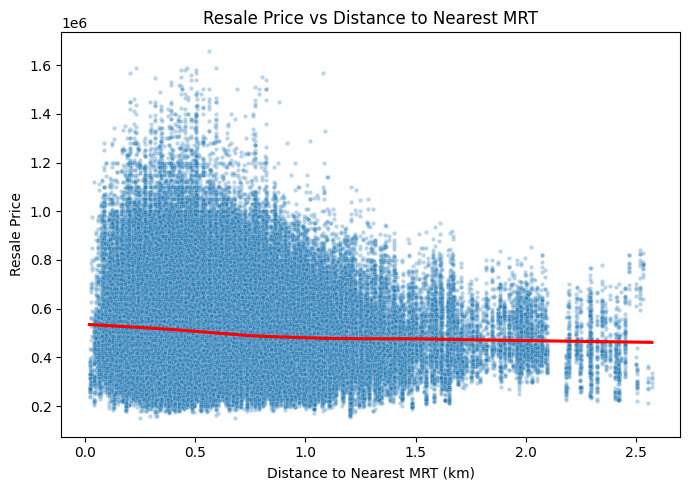

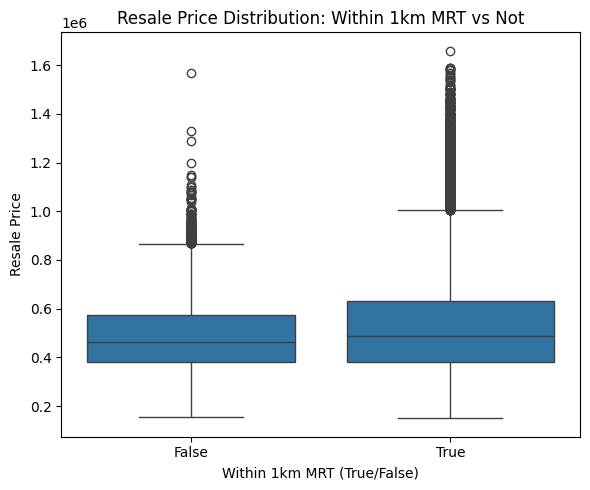

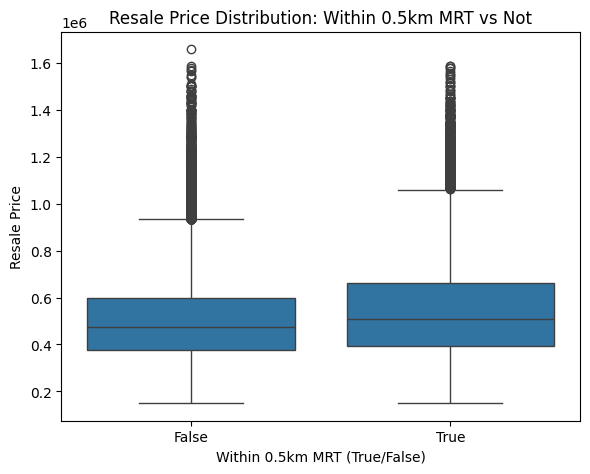

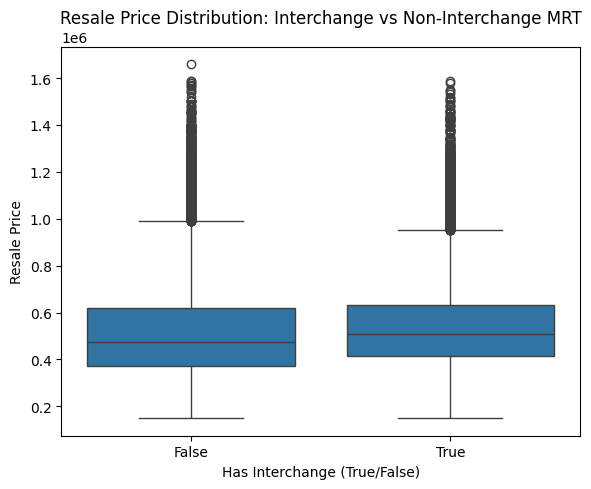

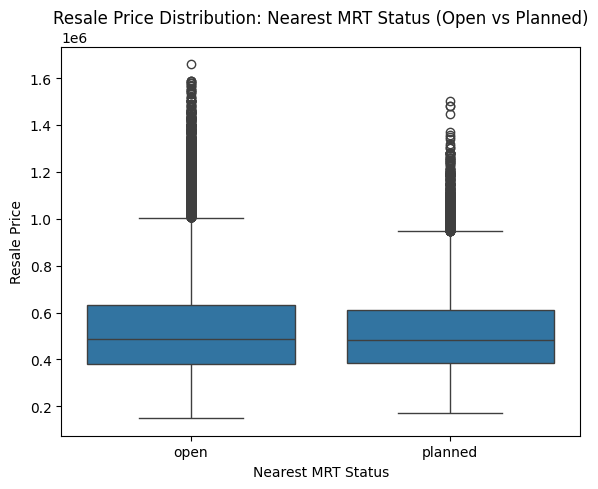

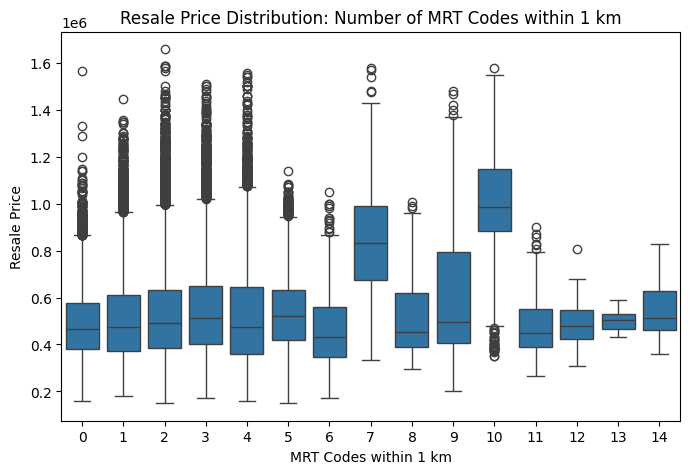

In [ ]:
df = df_train_with_HDB_MRT_info.copy()

# Scatter: resale price vs distance to MRT
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="nearest_mrt_distance_km", y="RESALE_PRICE",
                alpha=0.3, s=10)
sns.regplot(data=df, x="nearest_mrt_distance_km", y="RESALE_PRICE",
            scatter=False, color="red", lowess=True)
plt.title("Resale Price vs Distance to Nearest MRT")
plt.xlabel("Distance to Nearest MRT (km)")
plt.ylabel("Resale Price")
plt.tight_layout()
plt.show()

# Boxplot: Within 1km vs not
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x="within_1km", y="RESALE_PRICE")
plt.title("Resale Price Distribution: Within 1km MRT vs Not")
plt.xlabel("Within 1km MRT (True/False)")
plt.ylabel("Resale Price")
plt.tight_layout()
plt.show()

# Boxplot: Within 0.5km vs not
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x="within_0.5km", y="RESALE_PRICE")
plt.title("Resale Price Distribution: Within 0.5km MRT vs Not")
plt.xlabel("Within 0.5km MRT (True/False)")
plt.ylabel("Resale Price")
plt.tight_layout()
plt.show()

# Boxplot: Interchange vs not
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x="has_interchange", y="RESALE_PRICE")
plt.title("Resale Price Distribution: Interchange vs Non-Interchange MRT")
plt.xlabel("Has Interchange (True/False)")
plt.ylabel("Resale Price")
plt.tight_layout()
plt.show()

# Boxplot: Open vs Planned nearest MRT
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x="nearest_mrt_status", y="RESALE_PRICE",
            order=["open","planned"])
plt.title("Resale Price Distribution: Nearest MRT Status (Open vs Planned)")
plt.xlabel("Nearest MRT Status")
plt.ylabel("Resale Price")
plt.tight_layout()
plt.show()

# Boxplot: Number of MRT codes within 1 km
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x="mrt_code_count_within_1km", y="RESALE_PRICE")
plt.title("Resale Price Distribution: Number of MRT Codes within 1 km")
plt.xlabel("MRT Codes within 1 km")
plt.ylabel("Resale Price")
plt.tight_layout()
plt.show()

In [ ]:
df_train_with_HDB_MRT_info.head()

,MONTH,TOWN,BLOCK,STREET,FLOOR_RANGE,FLOOR_AREA_SQM,ECO_CATEGORY,LEASE_COMMENCE_DATA,RESALE_PRICE,resale_price_per_sqm,...,REGION_west region,floor_category,nearest_mrt_distance_km,nearest_mrt_name,nearest_mrt_status,nearest_mrt_codes,mrt_code_count_within_1km,within_1km,within_0.5km,has_interchange
0,2020-10,woodlands,681B,woodlands drive 62,07 to 09,102.0,uncategorized,2000,420000.0,4117.647059,...,0,mid,0.306014,Admiralty MRT station,open,NS10,1,True,True,False
1,2021-07,bishan,264,bishan street 24,07 to 09,104.0,uncategorized,1992,585000.0,5625.000000,...,0,mid,0.786298,Teck Ghee MRT station,planned,CR12,1,True,False,False
2,2021-05,bukit panjang,520,jelapang road,19 to 21,102.0,uncategorized,1998,450000.0,4411.764706,...,1,high,1.052540,Bukit Panjang MRT/LRT station,open,"BP6,DT1",0,False,False,True
3,2021-08,punggol,121B,edgedale plains,16 to 18,93.0,uncategorized,2017,465000.0,5000.000000,...,0,high,0.872296,Riviera MRT/LRT station,planned,"CP3,PE4",2,True,False,True
4,2023-05,hougang,997B,buangkok crescent,10 to 12,113.0,uncategorized,2018,710000.0,6283.185841,...,0,mid,1.342862,Buangkok MRT station,open,NE15,0,False,False,False


## Hawker Center data

### Merging dataset with Hawker info / generating features

In [ ]:
# Building df_train_with_HDB_MRT_Hawker_info
R_KM = 6371.0

haw = df_hawkers.copy()
df_train_with_HDB_MRT_Hawker_info = df_train_with_HDB_MRT_info.copy()

# Build BallTree (radians)
haw_rad = np.radians(haw[["LATITUDE","LONGITUDE"]].to_numpy(dtype=float))
haw_tree = BallTree(haw_rad, metric="haversine")

# Query nearest hawker for each flat
pts_rad = np.radians(df_train_with_HDB_MRT_Hawker_info[["LATITUDE","LONGITUDE"]].to_numpy(dtype=float))

dist_rad, idx = haw_tree.query(pts_rad, k=1)
nearest_idx = idx.ravel()
df_train_with_HDB_MRT_Hawker_info["nearest_hawker_distance_km"] = dist_rad.ravel() * R_KM
df_train_with_HDB_MRT_Hawker_info["nearest_hawker_name"]        = haw.iloc[nearest_idx]["NAME"].to_numpy()

# Attach hawker attributes for the nearest hawker
attrs = haw[["NAME","TYPE","OWNER","NUMBER_OF_STALLS"]]
df_train_with_HDB_MRT_Hawker_info = df_train_with_HDB_MRT_Hawker_info.merge(
    attrs, how="left", left_on="nearest_hawker_name", right_on="NAME"
).drop(columns=["NAME"])

# Walkability + counts using radius queries
idx_lists_1km  = haw_tree.query_radius(pts_rad, r=1.0 / R_KM)   # neighbors within 1 km
idx_lists_05km = haw_tree.query_radius(pts_rad, r=0.5 / R_KM)   # neighbors within 0.5 km

df_train_with_HDB_MRT_Hawker_info["hawker_within_1km"]   = [len(ix) > 0 for ix in idx_lists_1km]
df_train_with_HDB_MRT_Hawker_info["hawker_within_0.5km"] = [len(ix) > 0 for ix in idx_lists_05km]
df_train_with_HDB_MRT_Hawker_info["hawker_count_within_1km"]   = [len(ix) for ix in idx_lists_1km]
df_train_with_HDB_MRT_Hawker_info["hawker_count_within_0.5km"] = [len(ix) for ix in idx_lists_05km]

df_train_with_HDB_MRT_Hawker_info.head()

,MONTH,TOWN,BLOCK,STREET,FLOOR_RANGE,FLOOR_AREA_SQM,ECO_CATEGORY,LEASE_COMMENCE_DATA,RESALE_PRICE,resale_price_per_sqm,date,year,month_num,months_since_start,flat_age,remaining_lease,short_lease_flag,log_remaining_lease,FLAT_TYPE_1-room,FLAT_TYPE_2-room,FLAT_TYPE_3-room,FLAT_TYPE_4-room,FLAT_TYPE_5-room,FLAT_TYPE_executive,FLAT_TYPE_multi-generation,FLAT_MODEL_2 room,FLAT_MODEL_3gen,FLAT_MODEL_adjoined flat,FLAT_MODEL_apartment,FLAT_MODEL_dbss,FLAT_MODEL_improved,FLAT_MODEL_improved maisonette,FLAT_MODEL_maisonette,FLAT_MODEL_model a,FLAT_MODEL_model a maisonette,FLAT_MODEL_model a2,FLAT_MODEL_multi generation,FLAT_MODEL_new generation,FLAT_MODEL_premium apartment,FLAT_MODEL_premium apartment loft,FLAT_MODEL_premium maisonette,FLAT_MODEL_simplified,FLAT_MODEL_standard,FLAT_MODEL_terrace,FLAT_MODEL_type s1,FLAT_MODEL_type s2,POSTAL_CODE,LATITUDE,LONGITUDE,MAX_FLOOR,SUBZONE,PLANNING_AREA,PLANNING_AREA_TE,TOWN_TE,REGION_central region,REGION_east region,REGION_north region,REGION_north-east region,REGION_west region,floor_category_high,floor_category_low,floor_category_mid,nearest_mrt_distance_km,nearest_mrt_name,nearest_mrt_status,nearest_mrt_codes,mrt_code_count_within_1km,nearest_hawker_distance_km,nearest_hawker_name,TYPE,OWNER,NUMBER_OF_STALLS,hawker_within_1km,hawker_within_0.5km,hawker_count_within_1km,hawker_count_within_0.5km
0,2020-10,woodlands,681B,woodlands drive 62,07 to 09,102.0,uncategorized,2000,420000.0,4117.647059,2020-10-01,2020,10,46,20,79,0,4.382027,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,732681,1.439325,103.803324,14,woodlands east,woodlands,4513.172609,4513.172609,0,0,1,0,0,0,0,1,0.306014,Admiralty MRT station,open,NS10,1,2.683955,Blk 4A Woodlands Centre Road,HC,HDB,78,False,False,0,0
1,2021-07,bishan,264,bishan street 24,07 to 09,104.0,uncategorized,1992,585000.0,5625.000000,2021-07-01,2021,7,55,29,70,0,4.262680,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,570264,1.358659,103.842050,16,marymount,bishan,6483.349121,6483.349121,1,0,0,0,0,0,0,1,0.786298,Teck Ghee MRT station,planned,CR12,1,0.916936,Blk 341 Ang Mo Kio Ave 1,MHC,HDB,118,True,False,4,0
2,2021-05,bukit panjang,520,jelapang road,19 to 21,102.0,uncategorized,1998,450000.0,4411.764706,2021-05-01,2021,5,53,23,76,0,4.343805,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,670520,1.386468,103.766508,20,saujana,bukit panjang,4872.035338,4872.035338,0,0,0,0,1,1,0,0,1.052540,Bukit Panjang MRT/LRT station,open,"BP6,DT1",0,5.364143,Bukit Timah Market,MHC,Government,179,False,False,0,0
3,2021-08,punggol,121B,edgedale plains,16 to 18,93.0,uncategorized,2017,465000.0,5000.000000,2021-08-01,2021,8,56,4,95,0,4.564348,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,822121,1.393089,103.909042,17,punggol field,punggol,5672.726419,5672.726419,0,0,0,1,0,1,0,0,0.872296,Riviera MRT/LRT station,planned,"CP3,PE4",2,4.563651,Kovan Market & Food Centre,MHC,HDB,186,False,False,0,0
4,2023-05,hougang,997B,buangkok crescent,10 to 12,113.0,uncategorized,2018,710000.0,6283.185841,2023-05-01,2023,5,77,5,94,0,4.553877,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,532997,1.385902,103.881387,16,trafalgar,hougang,5181.523244,5181.523244,0,0,0,1,0,0,0,1,1.342862,Buangkok MRT station,open,NE15,0,2.921355,Chomp Chomp Food Centre,HC,Government,36,False,False,0,0


### Analysis on derived features

array([[<Axes: title={'center': 'nearest_hawker_distance_km'}>]],
      dtype=object)

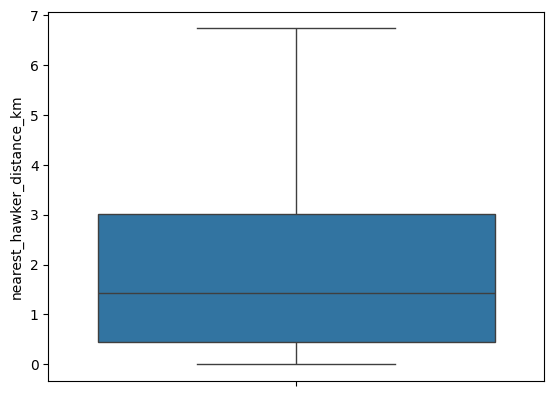

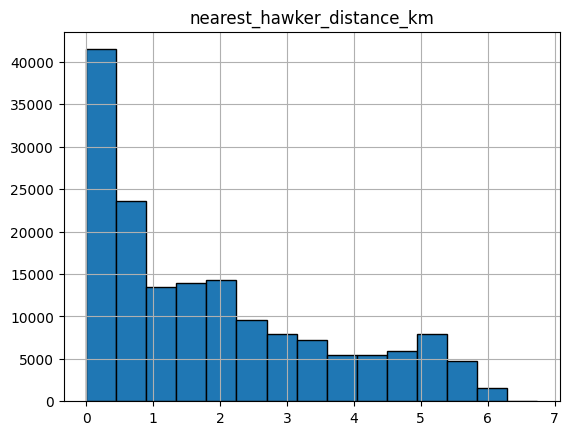

In [ ]:
sns.boxplot(df_train_with_HDB_MRT_Hawker_info["nearest_hawker_distance_km"])

df_train_with_HDB_MRT_Hawker_info.hist(column='nearest_hawker_distance_km', bins=15, edgecolor='black')

In [ ]:
df = df_train_with_HDB_MRT_Hawker_info.copy()

# Continuous features
corr_dist_hawker = df[['nearest_hawker_distance_km','RESALE_PRICE']].corr(method='spearman').loc['nearest_hawker_distance_km','RESALE_PRICE']
corr_hawker_cnt  = df[['hawker_count_within_1km','RESALE_PRICE']].corr(method='spearman').loc['hawker_count_within_1km','RESALE_PRICE']

# Binary features (cast to int for clarity)
df["hawker_within_1km"]   = df["hawker_within_1km"].astype(int)
df["hawker_within_0.5km"] = df["hawker_within_0.5km"].astype(int)

binary_cols = ["hawker_within_1km", "hawker_within_0.5km"]

corrs = {col: df[[col,'RESALE_PRICE']].corr(method='spearman').loc[col,'RESALE_PRICE'] for col in binary_cols}

# Print results
print(f"Spearman(nearest_hawker_distance_km, RESALE_PRICE) = {corr_dist_hawker:.4f}")
print(f"Spearman(hawker_count_within_1km, RESALE_PRICE)    = {corr_hawker_cnt:.4f}")

for col, val in corrs.items():
    print(f"Spearman({col}, RESALE_PRICE) = {val:.4f}")

Spearman(nearest_hawker_distance_km, RESALE_PRICE) = 0.0818
Spearman(hawker_count_within_1km, RESALE_PRICE)    = -0.0483
Spearman(hawker_within_1km, RESALE_PRICE) = -0.0578
Spearman(hawker_within_0.5km, RESALE_PRICE) = -0.0959


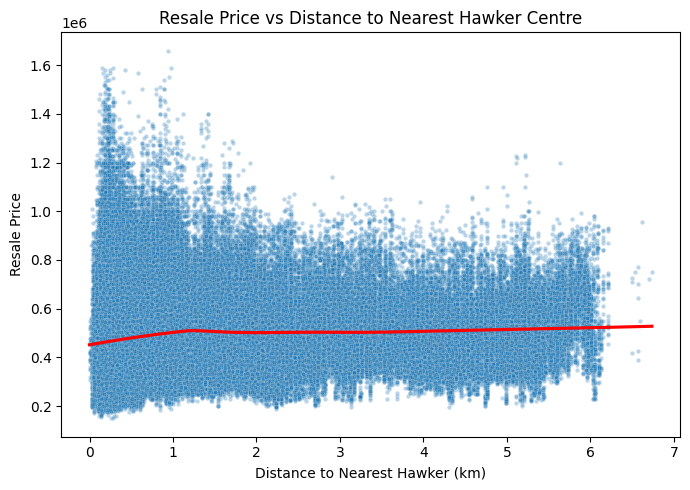

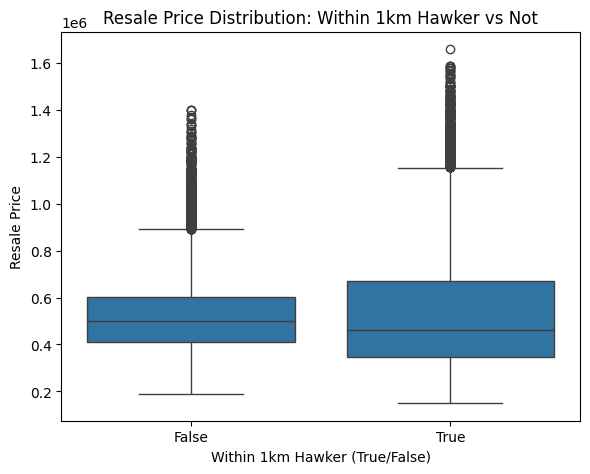

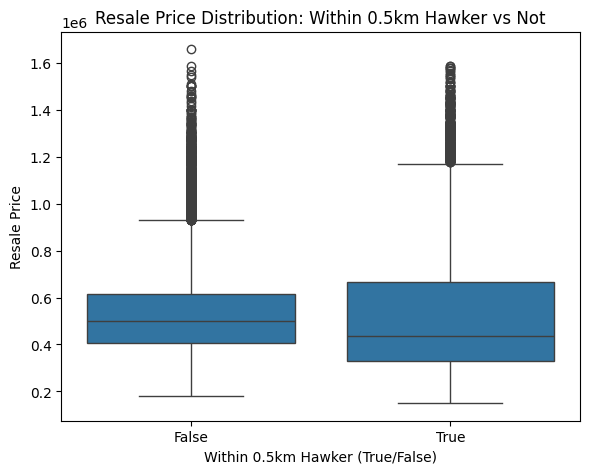

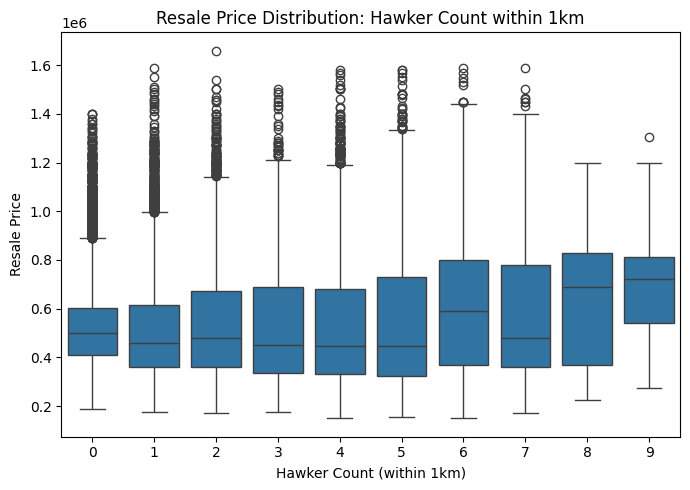

In [ ]:
df = df_train_with_HDB_MRT_Hawker_info.copy()

# Scatter: resale price vs distance to nearest hawker
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="nearest_hawker_distance_km", y="RESALE_PRICE",
                alpha=0.3, s=10)
sns.regplot(data=df, x="nearest_hawker_distance_km", y="RESALE_PRICE",
            scatter=False, color="red", lowess=True)
plt.title("Resale Price vs Distance to Nearest Hawker Centre")
plt.xlabel("Distance to Nearest Hawker (km)")
plt.ylabel("Resale Price")
plt.tight_layout()
plt.show()

# Boxplot: Within 1km hawker vs not
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x="hawker_within_1km", y="RESALE_PRICE")
plt.title("Resale Price Distribution: Within 1km Hawker vs Not")
plt.xlabel("Within 1km Hawker (True/False)")
plt.ylabel("Resale Price")
plt.tight_layout()
plt.show()

# Boxplot: Within 0.5km hawker vs not
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x="hawker_within_0.5km", y="RESALE_PRICE")
plt.title("Resale Price Distribution: Within 0.5km Hawker vs Not")
plt.xlabel("Within 0.5km Hawker (True/False)")
plt.ylabel("Resale Price")
plt.tight_layout()
plt.show()

# Boxplot: Hawker count within 1km
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x="hawker_count_within_1km", y="RESALE_PRICE")
plt.title("Resale Price Distribution: Hawker Count within 1km")
plt.xlabel("Hawker Count (within 1km)")
plt.ylabel("Resale Price")
plt.tight_layout()
plt.show()

In [ ]:
df_train_with_HDB_MRT_Hawker_info.head()

,MONTH,TOWN,BLOCK,STREET,FLOOR_RANGE,FLOOR_AREA_SQM,ECO_CATEGORY,LEASE_COMMENCE_DATA,RESALE_PRICE,resale_price_per_sqm,...,has_interchange,nearest_hawker_distance_km,nearest_hawker_name,TYPE,OWNER,NUMBER_OF_STALLS,hawker_within_1km,hawker_within_0.5km,hawker_count_within_1km,hawker_count_within_0.5km
0,2020-10,woodlands,681B,woodlands drive 62,07 to 09,102.0,uncategorized,2000,420000.0,4117.647059,...,False,2.683955,Blk 4A Woodlands Centre Road,HC,HDB,78,False,False,0,0
1,2021-07,bishan,264,bishan street 24,07 to 09,104.0,uncategorized,1992,585000.0,5625.000000,...,False,0.916936,Blk 341 Ang Mo Kio Ave 1,MHC,HDB,118,True,False,4,0
2,2021-05,bukit panjang,520,jelapang road,19 to 21,102.0,uncategorized,1998,450000.0,4411.764706,...,True,5.364143,Bukit Timah Market,MHC,Government,179,False,False,0,0
3,2021-08,punggol,121B,edgedale plains,16 to 18,93.0,uncategorized,2017,465000.0,5000.000000,...,True,4.563651,Kovan Market & Food Centre,MHC,HDB,186,False,False,0,0
4,2023-05,hougang,997B,buangkok crescent,10 to 12,113.0,uncategorized,2018,710000.0,6283.185841,...,False,2.921355,Chomp Chomp Food Centre,HC,Government,36,False,False,0,0


## Shopping Malls data

### Merging dataset with Shopping Mall info / generating features

In [ ]:
df_train_with_HDB_MRT_Hawker_Mall_info = add_location_features(df_train_with_HDB_MRT_Hawker_info, df_shopping_malls, name="mall")

df_train_with_HDB_MRT_Hawker_Mall_info.head()

,MONTH,TOWN,BLOCK,STREET,FLOOR_RANGE,FLOOR_AREA_SQM,ECO_CATEGORY,LEASE_COMMENCE_DATA,RESALE_PRICE,resale_price_per_sqm,date,year,month_num,months_since_start,flat_age,remaining_lease,short_lease_flag,log_remaining_lease,FLAT_TYPE_1-room,FLAT_TYPE_2-room,FLAT_TYPE_3-room,FLAT_TYPE_4-room,FLAT_TYPE_5-room,FLAT_TYPE_executive,FLAT_TYPE_multi-generation,FLAT_MODEL_2 room,FLAT_MODEL_3gen,FLAT_MODEL_adjoined flat,FLAT_MODEL_apartment,FLAT_MODEL_dbss,FLAT_MODEL_improved,FLAT_MODEL_improved maisonette,FLAT_MODEL_maisonette,FLAT_MODEL_model a,FLAT_MODEL_model a maisonette,FLAT_MODEL_model a2,FLAT_MODEL_multi generation,FLAT_MODEL_new generation,FLAT_MODEL_premium apartment,FLAT_MODEL_premium apartment loft,FLAT_MODEL_premium maisonette,FLAT_MODEL_simplified,FLAT_MODEL_standard,FLAT_MODEL_terrace,FLAT_MODEL_type s1,FLAT_MODEL_type s2,POSTAL_CODE,LATITUDE,LONGITUDE,MAX_FLOOR,SUBZONE,PLANNING_AREA,PLANNING_AREA_TE,TOWN_TE,REGION_central region,REGION_east region,REGION_north region,REGION_north-east region,REGION_west region,floor_category_high,floor_category_low,floor_category_mid,nearest_mrt_distance_km,nearest_mrt_name,nearest_mrt_status,nearest_mrt_codes,mrt_code_count_within_1km,nearest_hawker_distance_km,nearest_hawker_name,TYPE,OWNER,NUMBER_OF_STALLS,hawker_within_1km,hawker_within_0.5km,hawker_count_within_1km,hawker_count_within_0.5km,nearest_mall_distance_km,nearest_mall_name,mall_within_1km,mall_within_0.5km,mall_count_within_1km,mall_count_within_0.5km
0,2020-10,woodlands,681B,woodlands drive 62,07 to 09,102.0,uncategorized,2000,420000.0,4117.647059,2020-10-01,2020,10,46,20,79,0,4.382027,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,732681,1.439325,103.803324,14,woodlands east,woodlands,4513.172609,4513.172609,0,0,1,0,0,0,0,1,0.306014,Admiralty MRT station,open,NS10,1,2.683955,Blk 4A Woodlands Centre Road,HC,HDB,78,False,False,0,0,1.994702,Causeway Point,False,False,0,0
1,2021-07,bishan,264,bishan street 24,07 to 09,104.0,uncategorized,1992,585000.0,5625.000000,2021-07-01,2021,7,55,29,70,0,4.262680,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,570264,1.358659,103.842050,16,marymount,bishan,6483.349121,6483.349121,1,0,0,0,0,0,0,1,0.786298,Teck Ghee MRT station,planned,CR12,1,0.916936,Blk 341 Ang Mo Kio Ave 1,MHC,HDB,118,True,False,4,0,1.176139,Junction 8,False,False,0,0
2,2021-05,bukit panjang,520,jelapang road,19 to 21,102.0,uncategorized,1998,450000.0,4411.764706,2021-05-01,2021,5,53,23,76,0,4.343805,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,670520,1.386468,103.766508,20,saujana,bukit panjang,4872.035338,4872.035338,0,0,0,0,1,1,0,0,1.052540,Bukit Panjang MRT/LRT station,open,"BP6,DT1",0,5.364143,Bukit Timah Market,MHC,Government,179,False,False,0,0,0.980543,Junction 10,True,False,1,0
3,2021-08,punggol,121B,edgedale plains,16 to 18,93.0,uncategorized,2017,465000.0,5000.000000,2021-08-01,2021,8,56,4,95,0,4.564348,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,822121,1.393089,103.909042,17,punggol field,punggol,5672.726419,5672.726419,0,0,0,1,0,1,0,0,0.872296,Riviera MRT/LRT station,planned,"CP3,PE4",2,4.563651,Kovan Market & Food Centre,MHC,HDB,186,False,False,0,0,0.463143,Punggol Plaza,True,True,1,1
4,2023-05,hougang,997B,buangkok crescent,10 to 12,113.0,uncategorized,2018,710000.0,6283.185841,2023-05-01,2023,5,77,5,94,0,4.553877,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,532997,1.385902,103.881387,16,trafalgar,hougang,5181.523244,5181.523244,0,0,0,1,0,0,0,1,1.342862,Buangkok MRT station,open,NE15,0,2.921355,Chomp Chomp Food Centre,HC,Government,36,False,False,0,0,0.851672,The Seletar Mall,True,False,1,0


### Analysis on derived features

array([[<Axes: title={'center': 'nearest_mall_distance_km'}>]],
      dtype=object)

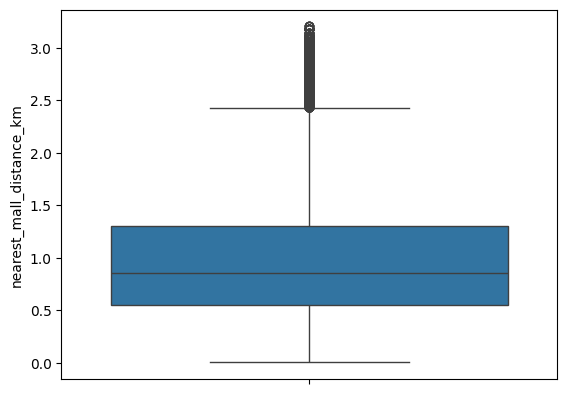

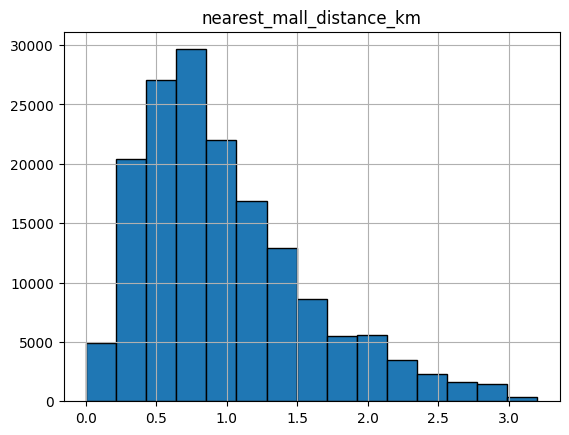

In [ ]:
sns.boxplot(df_train_with_HDB_MRT_Hawker_Mall_info["nearest_mall_distance_km"])

df_train_with_HDB_MRT_Hawker_Mall_info.hist(column='nearest_mall_distance_km', bins=15, edgecolor='black')

In [ ]:
df = df_train_with_HDB_MRT_Hawker_Mall_info.copy()

# Continuous features
corr_dist_mall = df[['nearest_mall_distance_km','RESALE_PRICE']].corr(method='spearman').loc['nearest_mall_distance_km','RESALE_PRICE']
corr_mall_cnt  = df[['mall_count_within_1km','RESALE_PRICE']].corr(method='spearman').loc['mall_count_within_1km','RESALE_PRICE']

# Binary features (cast to int for clarity)
df["mall_within_1km"]   = df["mall_within_1km"].astype(int)
df["mall_within_0.5km"] = df["mall_within_0.5km"].astype(int)

binary_cols = ["mall_within_1km", "mall_within_0.5km"]

corrs = {col: df[[col,'RESALE_PRICE']].corr(method='spearman').loc[col,'RESALE_PRICE'] for col in binary_cols}

# Print results
print(f"Spearman(nearest_mall_distance_km, RESALE_PRICE) = {corr_dist_mall:.4f}")
print(f"Spearman(mall_count_within_1km, RESALE_PRICE)    = {corr_mall_cnt:.4f}")

for col, val in corrs.items():
    print(f"Spearman({col}, RESALE_PRICE) = {val:.4f}")

Spearman(nearest_mall_distance_km, RESALE_PRICE) = -0.1219
Spearman(mall_count_within_1km, RESALE_PRICE)    = 0.0983
Spearman(mall_within_1km, RESALE_PRICE) = 0.0944
Spearman(mall_within_0.5km, RESALE_PRICE) = 0.0954


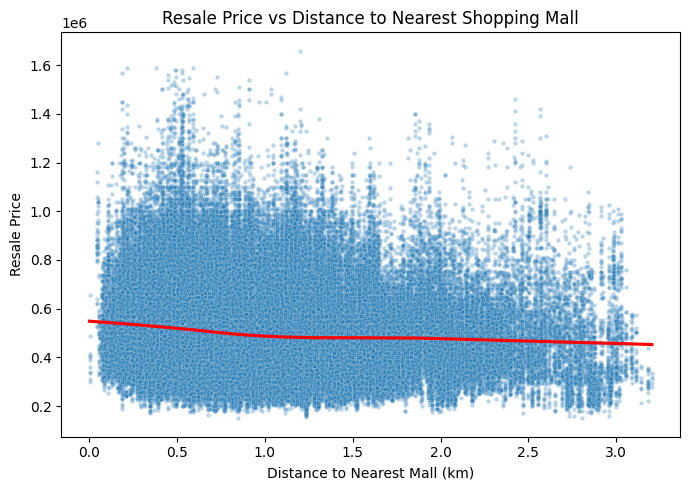

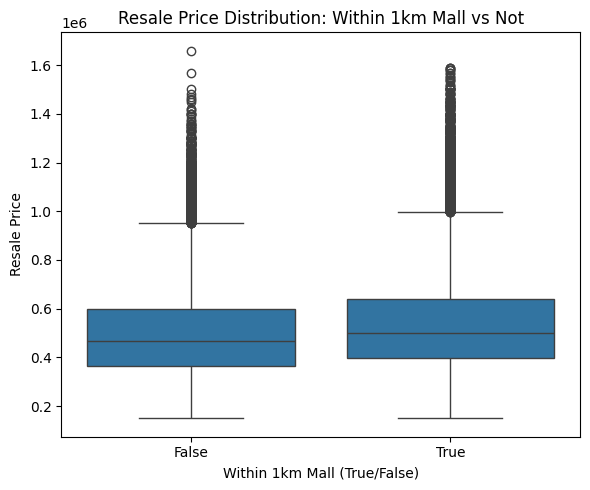

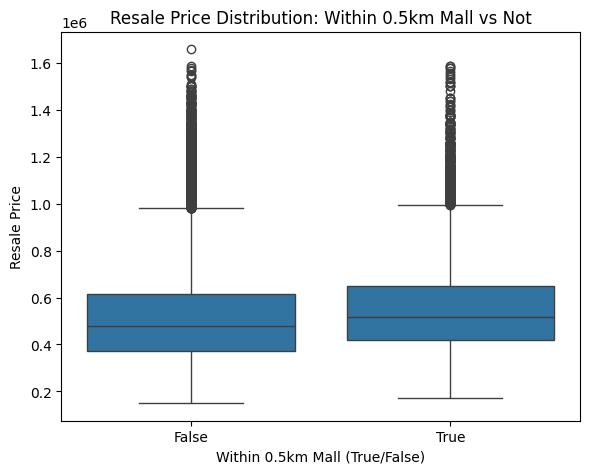

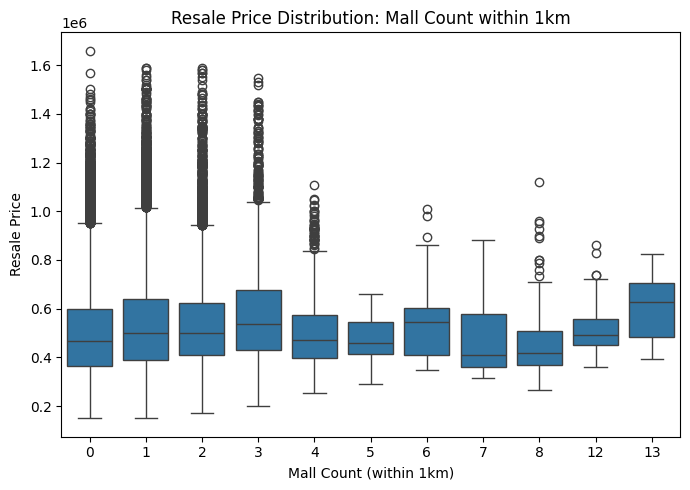

In [ ]:
df = df_train_with_HDB_MRT_Hawker_Mall_info.copy()

# Scatter: resale price vs distance to nearest mall
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="nearest_mall_distance_km", y="RESALE_PRICE",
                alpha=0.3, s=10)
sns.regplot(data=df, x="nearest_mall_distance_km", y="RESALE_PRICE",
            scatter=False, color="red", lowess=True)
plt.title("Resale Price vs Distance to Nearest Shopping Mall")
plt.xlabel("Distance to Nearest Mall (km)")
plt.ylabel("Resale Price")
plt.tight_layout()
plt.show()

# Boxplot: Within 1km mall vs not
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x="mall_within_1km", y="RESALE_PRICE")
plt.title("Resale Price Distribution: Within 1km Mall vs Not")
plt.xlabel("Within 1km Mall (True/False)")
plt.ylabel("Resale Price")
plt.tight_layout()
plt.show()

# Boxplot: Within 0.5km mall vs not
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x="mall_within_0.5km", y="RESALE_PRICE")
plt.title("Resale Price Distribution: Within 0.5km Mall vs Not")
plt.xlabel("Within 0.5km Mall (True/False)")
plt.ylabel("Resale Price")
plt.tight_layout()
plt.show()

# Boxplot: Mall count within 1km
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x="mall_count_within_1km", y="RESALE_PRICE")
plt.title("Resale Price Distribution: Mall Count within 1km")
plt.xlabel("Mall Count (within 1km)")
plt.ylabel("Resale Price")
plt.tight_layout()
plt.show()


## School data

### Merging dataset with primary & secondary schools info / generating features

In [ ]:
df_train_with_HDB_MRT_Hawker_Mall_School_info = add_location_features(df_train_with_HDB_MRT_Hawker_Mall_info, df_pri_schools, name="pri_school")

df_train_with_HDB_MRT_Hawker_Mall_School_info.head()

,MONTH,TOWN,BLOCK,STREET,FLOOR_RANGE,FLOOR_AREA_SQM,ECO_CATEGORY,LEASE_COMMENCE_DATA,RESALE_PRICE,resale_price_per_sqm,date,year,month_num,months_since_start,flat_age,remaining_lease,short_lease_flag,log_remaining_lease,FLAT_TYPE_1-room,FLAT_TYPE_2-room,FLAT_TYPE_3-room,FLAT_TYPE_4-room,FLAT_TYPE_5-room,FLAT_TYPE_executive,FLAT_TYPE_multi-generation,FLAT_MODEL_2 room,FLAT_MODEL_3gen,FLAT_MODEL_adjoined flat,FLAT_MODEL_apartment,FLAT_MODEL_dbss,FLAT_MODEL_improved,FLAT_MODEL_improved maisonette,FLAT_MODEL_maisonette,FLAT_MODEL_model a,FLAT_MODEL_model a maisonette,FLAT_MODEL_model a2,FLAT_MODEL_multi generation,FLAT_MODEL_new generation,FLAT_MODEL_premium apartment,FLAT_MODEL_premium apartment loft,FLAT_MODEL_premium maisonette,FLAT_MODEL_simplified,FLAT_MODEL_standard,FLAT_MODEL_terrace,FLAT_MODEL_type s1,FLAT_MODEL_type s2,POSTAL_CODE,LATITUDE,LONGITUDE,MAX_FLOOR,SUBZONE,PLANNING_AREA,PLANNING_AREA_TE,TOWN_TE,REGION_central region,REGION_east region,REGION_north region,REGION_north-east region,REGION_west region,floor_category_high,floor_category_low,floor_category_mid,nearest_mrt_distance_km,nearest_mrt_name,nearest_mrt_status,nearest_mrt_codes,mrt_code_count_within_1km,nearest_hawker_distance_km,nearest_hawker_name,TYPE,OWNER,NUMBER_OF_STALLS,hawker_within_1km,hawker_within_0.5km,hawker_count_within_1km,hawker_count_within_0.5km,nearest_mall_distance_km,nearest_mall_name,mall_within_1km,mall_within_0.5km,mall_count_within_1km,mall_count_within_0.5km,nearest_pri_school_distance_km,nearest_pri_school_name,pri_school_within_1km,pri_school_within_0.5km,pri_school_count_within_1km,pri_school_count_within_0.5km
0,2020-10,woodlands,681B,woodlands drive 62,07 to 09,102.0,uncategorized,2000,420000.0,4117.647059,2020-10-01,2020,10,46,20,79,0,4.382027,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,732681,1.439325,103.803324,14,woodlands east,woodlands,4513.172609,4513.172609,0,0,1,0,0,0,0,1,0.306014,Admiralty MRT station,open,NS10,1,2.683955,Blk 4A Woodlands Centre Road,HC,HDB,78,False,False,0,0,1.994702,Causeway Point,False,False,0,0,0.168452,Greenwood Primary School,True,True,4,1
1,2021-07,bishan,264,bishan street 24,07 to 09,104.0,uncategorized,1992,585000.0,5625.000000,2021-07-01,2021,7,55,29,70,0,4.262680,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,570264,1.358659,103.842050,16,marymount,bishan,6483.349121,6483.349121,1,0,0,0,0,0,0,1,0.786298,Teck Ghee MRT station,planned,CR12,1,0.916936,Blk 341 Ang Mo Kio Ave 1,MHC,HDB,118,True,False,4,0,1.176139,Junction 8,False,False,0,0,0.532114,Catholic High School (Primary),True,False,1,0
2,2021-05,bukit panjang,520,jelapang road,19 to 21,102.0,uncategorized,1998,450000.0,4411.764706,2021-05-01,2021,5,53,23,76,0,4.343805,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,670520,1.386468,103.766508,20,saujana,bukit panjang,4872.035338,4872.035338,0,0,0,0,1,1,0,0,1.052540,Bukit Panjang MRT/LRT station,open,"BP6,DT1",0,5.364143,Bukit Timah Market,MHC,Government,179,False,False,0,0,0.980543,Junction 10,True,False,1,0,0.156784,Greenridge Primary School,True,True,5,2
3,2021-08,punggol,121B,edgedale plains,16 to 18,93.0,uncategorized,2017,465000.0,5000.000000,2021-08-01,2021,8,56,4,95,0,4.564348,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,822121,1.393089,103.909042,17,punggol field,punggol,5672.726419,5672.726419,0,0,0,1,0,1,0,0,0.872296,Riviera MRT/LRT station,planned,"CP3,PE4",2,4.563651,Kovan Market & Food Centre,MHC,HDB,186,False,False,0,0,0.463143,Punggol Plaza,True,True,1,1,0.177318,Mee Toh School,True,True,6,2
4,2023-05,hougang,997B,buangkok crescent,10 to 12,113.0,uncategorized,2018,710000.0,6283.185841,2023-05-01,2023,5,77,5,94,0,4.553877,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,532997,1.385902,103.881387,16,trafalgar,hougang,5181.523244,5181.523244,0,0,0,1,0,0,0,1,1.342862,Buangkok MRT station,open,NE15,0,2.921355,Chomp Chomp Food Centre,HC,Government,36,False,False,0,0,0.851672,The Seletar Mall,True,False,1,0,0.812018,Anchor Green Pri

In [ ]:
df_train_with_HDB_MRT_Hawker_Mall_School_info = add_location_features(df_train_with_HDB_MRT_Hawker_Mall_School_info, df_sec_schools, name="sec_school")

df_train_with_HDB_MRT_Hawker_Mall_School_info.head()

,MONTH,TOWN,BLOCK,STREET,FLOOR_RANGE,FLOOR_AREA_SQM,ECO_CATEGORY,LEASE_COMMENCE_DATA,RESALE_PRICE,resale_price_per_sqm,date,year,month_num,months_since_start,flat_age,remaining_lease,short_lease_flag,log_remaining_lease,FLAT_TYPE_1-room,FLAT_TYPE_2-room,FLAT_TYPE_3-room,FLAT_TYPE_4-room,FLAT_TYPE_5-room,FLAT_TYPE_executive,FLAT_TYPE_multi-generation,FLAT_MODEL_2 room,FLAT_MODEL_3gen,FLAT_MODEL_adjoined flat,FLAT_MODEL_apartment,FLAT_MODEL_dbss,FLAT_MODEL_improved,FLAT_MODEL_improved maisonette,FLAT_MODEL_maisonette,FLAT_MODEL_model a,FLAT_MODEL_model a maisonette,FLAT_MODEL_model a2,FLAT_MODEL_multi generation,FLAT_MODEL_new generation,FLAT_MODEL_premium apartment,FLAT_MODEL_premium apartment loft,FLAT_MODEL_premium maisonette,FLAT_MODEL_simplified,FLAT_MODEL_standard,FLAT_MODEL_terrace,FLAT_MODEL_type s1,FLAT_MODEL_type s2,POSTAL_CODE,LATITUDE,LONGITUDE,MAX_FLOOR,SUBZONE,PLANNING_AREA,PLANNING_AREA_TE,TOWN_TE,REGION_central region,REGION_east region,REGION_north region,REGION_north-east region,REGION_west region,floor_category_high,floor_category_low,floor_category_mid,nearest_mrt_distance_km,nearest_mrt_name,nearest_mrt_status,nearest_mrt_codes,mrt_code_count_within_1km,nearest_hawker_distance_km,nearest_hawker_name,TYPE,OWNER,NUMBER_OF_STALLS,hawker_within_1km,hawker_within_0.5km,hawker_count_within_1km,hawker_count_within_0.5km,nearest_mall_distance_km,nearest_mall_name,mall_within_1km,mall_within_0.5km,mall_count_within_1km,mall_count_within_0.5km,nearest_pri_school_distance_km,nearest_pri_school_name,pri_school_within_1km,pri_school_within_0.5km,pri_school_count_within_1km,pri_school_count_within_0.5km,nearest_sec_school_distance_km,nearest_sec_school_name,sec_school_within_1km,sec_school_within_0.5km,sec_school_count_within_1km,sec_school_count_within_0.5km
0,2020-10,woodlands,681B,woodlands drive 62,07 to 09,102.0,uncategorized,2000,420000.0,4117.647059,2020-10-01,2020,10,46,20,79,0,4.382027,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,732681,1.439325,103.803324,14,woodlands east,woodlands,4513.172609,4513.172609,0,0,1,0,0,0,0,1,0.306014,Admiralty MRT station,open,NS10,1,2.683955,Blk 4A Woodlands Centre Road,HC,HDB,78,False,False,0,0,1.994702,Causeway Point,False,False,0,0,0.168452,Greenwood Primary School,True,True,4,1,0.268534,Spectra Secondary School,True,True,2,1
1,2021-07,bishan,264,bishan street 24,07 to 09,104.0,uncategorized,1992,585000.0,5625.000000,2021-07-01,2021,7,55,29,70,0,4.262680,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,570264,1.358659,103.842050,16,marymount,bishan,6483.349121,6483.349121,1,0,0,0,0,0,0,1,0.786298,Teck Ghee MRT station,planned,CR12,1,0.916936,Blk 341 Ang Mo Kio Ave 1,MHC,HDB,118,True,False,4,0,1.176139,Junction 8,False,False,0,0,0.532114,Catholic High School (Primary),True,False,1,0,0.404944,Whitley Secondary School,True,True,3,1
2,2021-05,bukit panjang,520,jelapang road,19 to 21,102.0,uncategorized,1998,450000.0,4411.764706,2021-05-01,2021,5,53,23,76,0,4.343805,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,670520,1.386468,103.766508,20,saujana,bukit panjang,4872.035338,4872.035338,0,0,0,0,1,1,0,0,1.052540,Bukit Panjang MRT/LRT station,open,"BP6,DT1",0,5.364143,Bukit Timah Market,MHC,Government,179,False,False,0,0,0.980543,Junction 10,True,False,1,0,0.156784,Greenridge Primary School,True,True,5,2,0.238378,Zhenghua Secondary School,True,True,2,1
3,2021-08,punggol,121B,edgedale plains,16 to 18,93.0,uncategorized,2017,465000.0,5000.000000,2021-08-01,2021,8,56,4,95,0,4.564348,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,822121,1.393089,103.909042,17,punggol field,punggol,5672.726419,5672.726419,0,0,0,1,0,1,0,0,0.872296,Riviera MRT/LRT station,planned,"CP3,PE4",2,4.563651,Kovan Market & Food Centre,MHC,HDB,186,False,False,0,0,0.463143,Punggol Plaza,True,True,1,1,0.177318,Mee Toh School,True,True,6,2,0.522089,Greendale Secondary School,True,False,3,0
4,2023-05,hougang,997B,buangkok crescent,10 to 12,113.0,uncategorized,2018,710000.0,6283.185841,

### Analysis on derived features

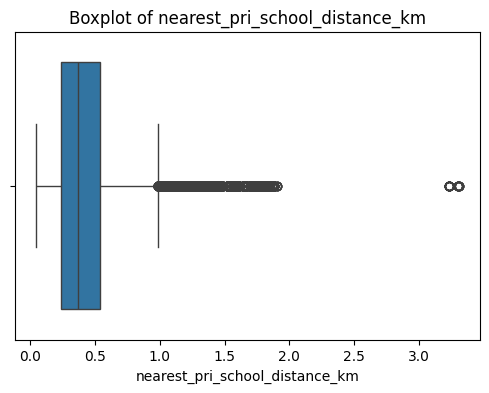

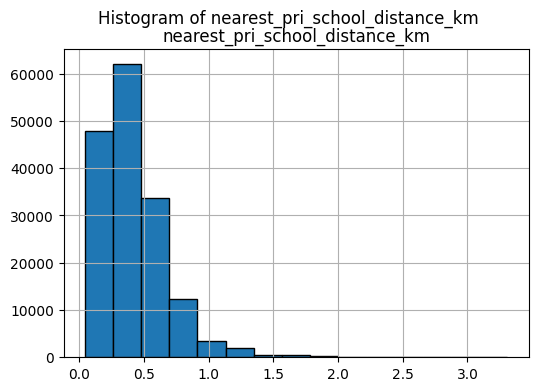

Spearman(nearest_pri_school_distance_km, RESALE_PRICE) = 0.0016
Spearman(pri_school_count_within_1km, RESALE_PRICE)  = -0.0370
Spearman(pri_school_within_1km, RESALE_PRICE) = 0.0213
Spearman(pri_school_within_0.5km, RESALE_PRICE) = -0.0097


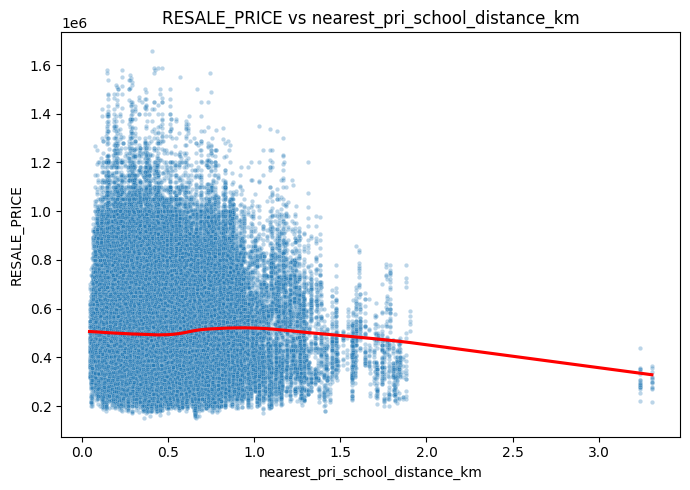

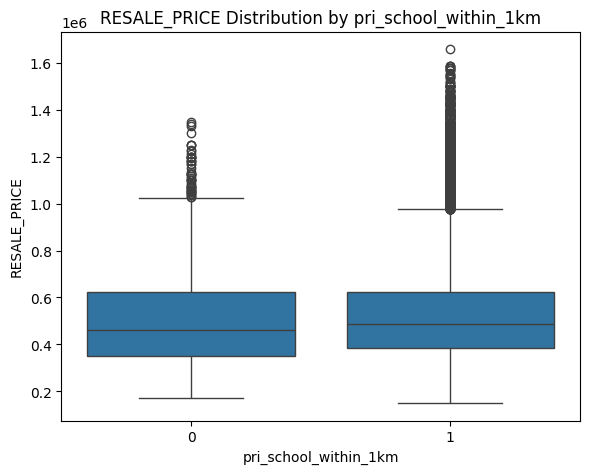

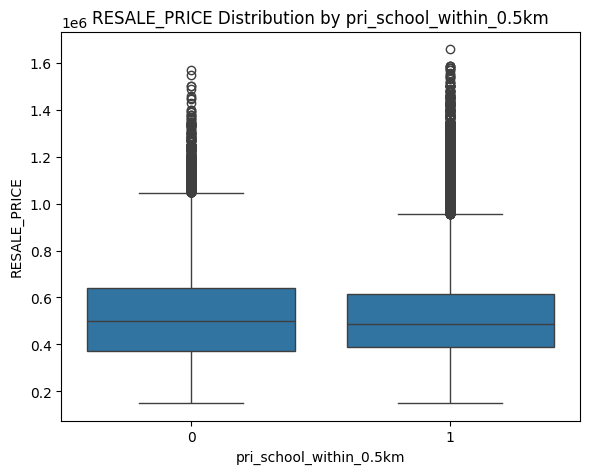

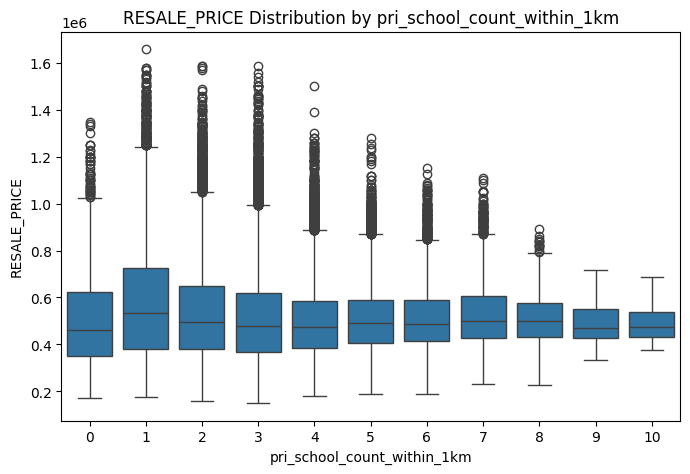

In [ ]:
analyse_features(df_train_with_HDB_MRT_Hawker_Mall_School_info, aux_name="pri_school")

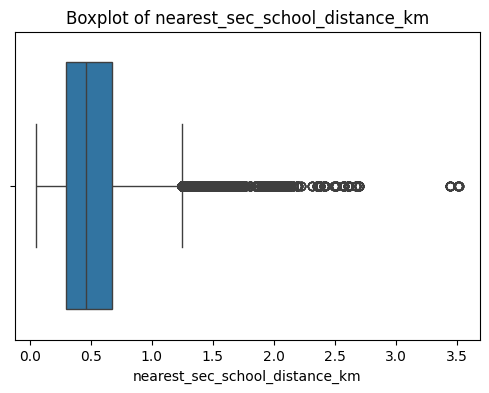

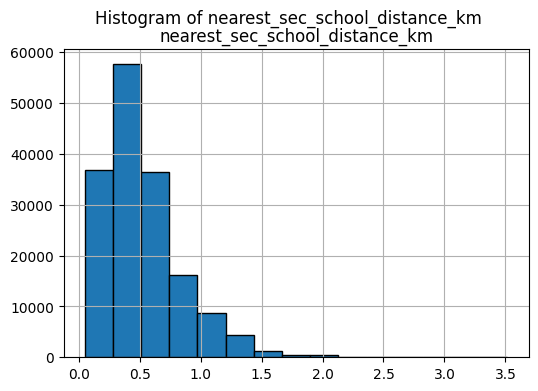

Spearman(nearest_sec_school_distance_km, RESALE_PRICE) = 0.0630
Spearman(sec_school_count_within_1km, RESALE_PRICE)  = -0.0044
Spearman(sec_school_within_1km, RESALE_PRICE) = -0.0713
Spearman(sec_school_within_0.5km, RESALE_PRICE) = -0.0474


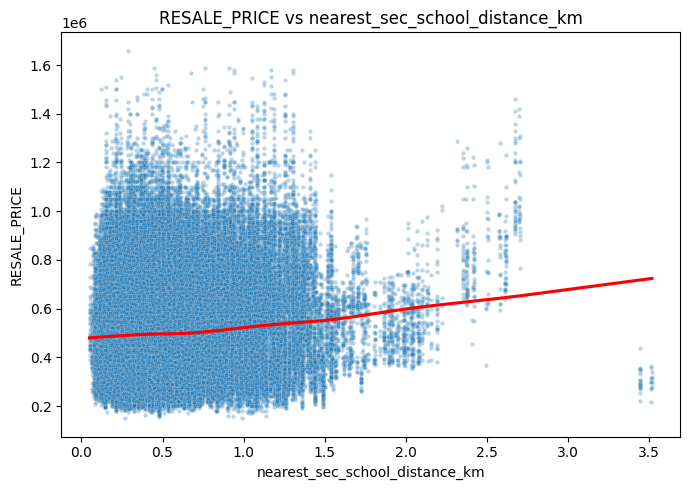

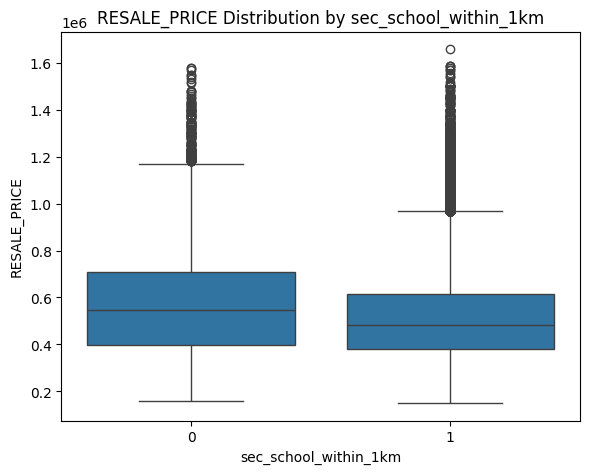

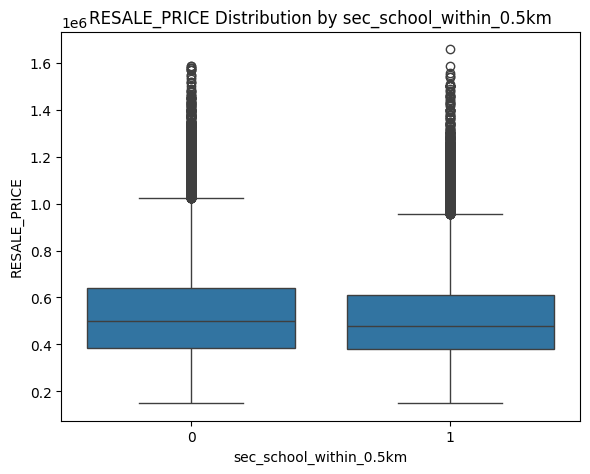

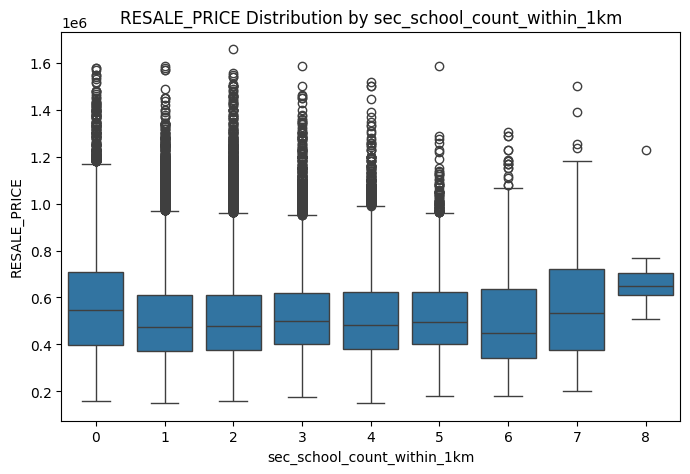

In [ ]:
analyse_features(df_train_with_HDB_MRT_Hawker_Mall_School_info, aux_name="sec_school")

# Determine final features

In [ ]:
# Create a table of column names and dtypes
cols_dtype = pd.DataFrame(df_train_with_HDB_MRT_Hawker_Mall_School_info.dtypes, columns=['dtype']).reset_index()
cols_dtype.rename(columns={'index':'column'}, inplace=True)

# Show all rows
pd.set_option('display.max_rows', None)

print(cols_dtype)

                               column           dtype
0                               MONTH          object
1                                TOWN          object
2                               BLOCK          object
3                              STREET          object
4                         FLOOR_RANGE          object
5                      FLOOR_AREA_SQM         float64
6                        ECO_CATEGORY          object
7                 LEASE_COMMENCE_DATA           int64
8                        RESALE_PRICE         float64
9                resale_price_per_sqm         float64
10                               date  datetime64[ns]
11                               year           int32
12                          month_num           int32
13                 months_since_start           int32
14                           flat_age           int64
15                    remaining_lease           int64
16                   short_lease_flag           int64
17                log_remain

In [ ]:
df_train_final = df_train_with_HDB_MRT_Hawker_Mall_School_info.copy()

In [ ]:
print(df_train_final.shape)
df_train_final.head()

(162570, 94)


,MONTH,TOWN,BLOCK,STREET,FLOOR_RANGE,FLOOR_AREA_SQM,ECO_CATEGORY,LEASE_COMMENCE_DATA,RESALE_PRICE,resale_price_per_sqm,date,year,month_num,months_since_start,flat_age,remaining_lease,short_lease_flag,log_remaining_lease,FLAT_TYPE_1-room,FLAT_TYPE_2-room,FLAT_TYPE_3-room,FLAT_TYPE_4-room,FLAT_TYPE_5-room,FLAT_TYPE_executive,FLAT_TYPE_multi-generation,FLAT_MODEL_2 room,FLAT_MODEL_3gen,FLAT_MODEL_adjoined flat,FLAT_MODEL_apartment,FLAT_MODEL_dbss,FLAT_MODEL_improved,FLAT_MODEL_improved maisonette,FLAT_MODEL_maisonette,FLAT_MODEL_model a,FLAT_MODEL_model a maisonette,FLAT_MODEL_model a2,FLAT_MODEL_multi generation,FLAT_MODEL_new generation,FLAT_MODEL_premium apartment,FLAT_MODEL_premium apartment loft,FLAT_MODEL_premium maisonette,FLAT_MODEL_simplified,FLAT_MODEL_standard,FLAT_MODEL_terrace,FLAT_MODEL_type s1,FLAT_MODEL_type s2,POSTAL_CODE,LATITUDE,LONGITUDE,MAX_FLOOR,SUBZONE,PLANNING_AREA,PLANNING_AREA_TE,TOWN_TE,REGION_central region,REGION_east region,REGION_north region,REGION_north-east region,REGION_west region,floor_category_high,floor_category_low,floor_category_mid,nearest_mrt_distance_km,nearest_mrt_name,nearest_mrt_status,nearest_mrt_codes,mrt_code_count_within_1km,nearest_hawker_distance_km,nearest_hawker_name,TYPE,OWNER,NUMBER_OF_STALLS,hawker_within_1km,hawker_within_0.5km,hawker_count_within_1km,hawker_count_within_0.5km,nearest_mall_distance_km,nearest_mall_name,mall_within_1km,mall_within_0.5km,mall_count_within_1km,mall_count_within_0.5km,nearest_pri_school_distance_km,nearest_pri_school_name,pri_school_within_1km,pri_school_within_0.5km,pri_school_count_within_1km,pri_school_count_within_0.5km,nearest_sec_school_distance_km,nearest_sec_school_name,sec_school_within_1km,sec_school_within_0.5km,sec_school_count_within_1km,sec_school_count_within_0.5km
0,2020-10,woodlands,681B,woodlands drive 62,07 to 09,102.0,uncategorized,2000,420000.0,4117.647059,2020-10-01,2020,10,46,20,79,0,4.382027,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,732681,1.439325,103.803324,14,woodlands east,woodlands,4513.172609,4513.172609,0,0,1,0,0,0,0,1,0.306014,Admiralty MRT station,open,NS10,1,2.683955,Blk 4A Woodlands Centre Road,HC,HDB,78,False,False,0,0,1.994702,Causeway Point,False,False,0,0,0.168452,Greenwood Primary School,True,True,4,1,0.268534,Spectra Secondary School,True,True,2,1
1,2021-07,bishan,264,bishan street 24,07 to 09,104.0,uncategorized,1992,585000.0,5625.000000,2021-07-01,2021,7,55,29,70,0,4.262680,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,570264,1.358659,103.842050,16,marymount,bishan,6483.349121,6483.349121,1,0,0,0,0,0,0,1,0.786298,Teck Ghee MRT station,planned,CR12,1,0.916936,Blk 341 Ang Mo Kio Ave 1,MHC,HDB,118,True,False,4,0,1.176139,Junction 8,False,False,0,0,0.532114,Catholic High School (Primary),True,False,1,0,0.404944,Whitley Secondary School,True,True,3,1
2,2021-05,bukit panjang,520,jelapang road,19 to 21,102.0,uncategorized,1998,450000.0,4411.764706,2021-05-01,2021,5,53,23,76,0,4.343805,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,670520,1.386468,103.766508,20,saujana,bukit panjang,4872.035338,4872.035338,0,0,0,0,1,1,0,0,1.052540,Bukit Panjang MRT/LRT station,open,"BP6,DT1",0,5.364143,Bukit Timah Market,MHC,Government,179,False,False,0,0,0.980543,Junction 10,True,False,1,0,0.156784,Greenridge Primary School,True,True,5,2,0.238378,Zhenghua Secondary School,True,True,2,1
3,2021-08,punggol,121B,edgedale plains,16 to 18,93.0,uncategorized,2017,465000.0,5000.000000,2021-08-01,2021,8,56,4,95,0,4.564348,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,822121,1.393089,103.909042,17,punggol field,punggol,5672.726419,5672.726419,0,0,0,1,0,1,0,0,0.872296,Riviera MRT/LRT station,planned,"CP3,PE4",2,4.563651,Kovan Market & Food Centre,MHC,HDB,186,False,False,0,0,0.463143,Punggol Plaza,True,True,1,1,0.177318,Mee Toh School,True,True,6,2,0.522089,Greendale Secondary School,True,False,3,0
4,2023-05,hougang,997B,buangkok crescent,10 to 12,113.0,uncategorized,2018,710000.0,6283.185841,

### Drop unnecessary features

In [ ]:
# Columns to drop (with reasons as inline annotations)
columns_to_drop = [
    # --- Group B: identifiers / text labels (high-cardinality, not generalizable) ---
    "BLOCK",                   # Block identifier; near-unique, encourages memorization/overfitting
    "POSTAL_CODE",             # Postal/zipcode is an ID-like locator; poor generalization, privacy-sensitive
    "STREET",                  # Street name is a textual ID; high-cardinality and unstable across time
    "PLANNING_AREA",           # Already Target encoded
    "TOWN",                    # Already Target encoded
    "SUBZONE",                 # Using planning_area_te instead
    "TYPE",                    # hawker type
    "OWNER",                   # hawker owner: HDB/government
    "nearest_hawker_name",     # Amenity NAME is an identifier; distance/density features carry the signal
    "nearest_mall_name",       # Same as above; use distances/counts instead of names
    "nearest_mrt_codes",       # Station code is an ID; prefer distance/proximity features
    "nearest_mrt_status",      # open/planned
    "nearest_mrt_name",        # Station name is an ID; redundant with distance
    "nearest_pri_school_name", # School name is an ID; keep distance/count features instead
    "nearest_sec_school_name", # Same as above
    "MONTH",                   # converted to year and month_num
    "date",                    # duplicate with MONTH
    "LEASE_COMMENCE_DATA",     # redundant once you have numeric lease age/remaining years
    "FLOOR_RANGE",             # redundant if numeric storey/floor features exist

    # --- Group A: target leakage (drop first) ---
    "resale_price_per_sqm",    # Leakage: equals RESALE_PRICE / FLOOR_AREA_SQM
]

# Drop only those columns that actually exist to avoid KeyErrors
existing_to_drop = [c for c in columns_to_drop if c in df_train_final.columns]

# Print what will be dropped (one per line)
print("Dropping the following columns:")
for c in existing_to_drop:
    print(f"- {c}")

# Perform the drop
df_train_final = df_train_final.drop(columns=existing_to_drop, errors="ignore")


Dropping the following columns:
- BLOCK
- POSTAL_CODE
- STREET
- nearest_hawker_name
- nearest_mall_name
- nearest_mrt_codes
- nearest_mrt_name
- nearest_pri_school_name
- nearest_sec_school_name
- resale_price_per_sqm


In [ ]:
candidates = [
    # Malls
    "mall_within_0.5km",
    "mall_within_1km",
    "mall_count_within_1km",
    # Hawkers
    "hawker_within_0.5km",
    "hawker_within_1km",
    "hawker_count_within_1km",
    # Primary schools
    "pri_school_within_0.5km",
    "pri_school_within_1km",
    "pri_school_count_within_1km",
    # Secondary schools
    "sec_school_within_0.5km",
    "sec_school_within_1km",
    "sec_school_count_within_1km",
]

to_drop = [c for c in candidates if c in df_train_final.columns]

print("Dropping Group D columns:")
for c in to_drop:
    print(f"- {c}")

# Drop them
df_train_final = df_train_final.drop(columns=to_drop, errors="ignore")

Dropping Group D columns:
- mall_within_0.5km
- mall_within_1km
- mall_count_within_1km
- hawker_within_0.5km
- hawker_within_1km
- hawker_count_within_1km
- pri_school_within_0.5km
- pri_school_within_1km
- pri_school_count_within_1km
- sec_school_within_0.5km
- sec_school_within_1km
- sec_school_count_within_1km


In [ ]:
import hashlib

# --- 1) Drop constant columns (only 1 non-null unique value, or entirely null) ---
orig_shape = df_train_final.shape

nunique_non_null = df_train_final.nunique(dropna=True)
const_non_null = nunique_non_null[nunique_non_null == 1].index.tolist()
all_null_cols = df_train_final.columns[df_train_final.isna().all()].tolist()
constant_cols = sorted(set(const_non_null + all_null_cols))

print("# CONSTANT_COLUMNS (dropping):")
for c in constant_cols:
    print(c)

df_train_final = df_train_final.drop(columns=constant_cols, errors="ignore")
print(f"\nShape after dropping constants: {orig_shape} -> {df_train_final.shape}")

# --- 2) Find EXACT duplicate columns ---
def column_signature(s: pd.Series) -> str:
    # Stable signature from dtype + per-value hashes (NaNs handled consistently)
    h = pd.util.hash_pandas_object(s, index=False)
    m = hashlib.md5()
    m.update(str(s.dtype).encode("utf-8"))
    m.update(h.values.tobytes())
    return m.hexdigest()

sig_map = {}
for col in df_train_final.columns:
    sig = column_signature(df_train_final[col])
    sig_map.setdefault(sig, []).append(col)

duplicate_groups = [cols for cols in sig_map.values() if len(cols) > 1]

print("\n# DUPLICATE_GROUPS (review & choose which to drop):")
for grp in duplicate_groups:
    print(", ".join(grp))


# CONSTANT_COLUMNS (dropping):
ECO_CATEGORY

Shape after dropping constants: (162570, 71) -> (162570, 70)

# DUPLICATE_GROUPS (review & choose which to drop):
FLAT_TYPE_multi-generation, FLAT_MODEL_multi generation


In [ ]:
def combine_exact_or_coalesce(df, new_col, col_a, col_b):
    """
    Create `new_col` from two source columns:
      - If columns are exactly equal (including NaNs), copy either one.
      - Otherwise, coalesce row-wise (prefer col_a, then col_b) and print a warning.
    Drops the source columns if they exist.
    """
    cols_present = [c for c in [col_a, col_b] if c in df.columns]
    if not cols_present:
        print(f"[skip] Neither {col_a} nor {col_b} found.")
        return df

    s1 = df[col_a] if col_a in df.columns else pd.Series([pd.NA] * len(df), index=df.index)
    s2 = df[col_b] if col_b in df.columns else pd.Series([pd.NA] * len(df), index=df.index)

    # Attempt dtype alignment for fair comparison
    if s1.dtype != s2.dtype:
        try:
            s1 = pd.to_numeric(s1, errors="coerce")
            s2 = pd.to_numeric(s2, errors="coerce")
        except Exception:
            pass

    equal_mask = (s1.eq(s2)) | (s1.isna() & s2.isna())
    if bool(equal_mask.all()):
        df[new_col] = s1.combine_first(s2)
        print(f"[ok] {col_a} and {col_b} are identical. Created {new_col}.")
    else:
        mismatches = int((~equal_mask).sum())
        df[new_col] = s1.combine_first(s2)
        print(f"[warn] {col_a} and {col_b} are NOT identical ({mismatches} mismatches). "
              f"Created {new_col} by coalescing {col_a} over {col_b}.")

    # Drop originals if present
    drop_list = [c for c in [col_a, col_b] if c in df.columns]
    df.drop(columns=drop_list, inplace=True, errors="ignore")
    print(f"[drop] {', '.join(drop_list)}")
    return df

# 1) Drop the 'flat model' column from the duplicate pair
flat_model_col = "FLAT_MODEL_multi generation"      # drop
if flat_model_col in df_train_final.columns:
    df_train_final.drop(columns=[flat_model_col], inplace=True, errors="ignore")
    print(f"[drop] {flat_model_col}")
else:
    print(f"[skip] {flat_model_col} not found.")

# Show resulting shape and a quick peek
print(f"\nDone. Current shape: {df_train_final.shape}")

[drop] FLAT_MODEL_multi generation

Done. Current shape: (162570, 69)


In [ ]:
print(df_train_final.shape)
df_train_final.head()

(162570, 69)


,TOWN,FLOOR_AREA_SQM,RESALE_PRICE,year,month_num,month_sin,month_cos,months_since_start,flat_age,remaining_lease,...,TYPE,OWNER,NUMBER_OF_STALLS,hawker_count_within_0.5km,nearest_mall_distance_km,mall_count_within_0.5km,nearest_pri_school_distance_km,pri_school_count_within_0.5km,nearest_sec_school_distance_km,sec_school_count_within_0.5km
0,woodlands,102.0,420000.0,2020,10,-0.866025,0.500000,46,20,79,...,HC,HDB,78,0,1.994702,0,0.168452,1,0.268534,1
1,bishan,104.0,585000.0,2021,7,-0.500000,-0.866025,55,29,70,...,MHC,HDB,118,0,1.176139,0,0.532114,0,0.404944,1
2,bukit panjang,102.0,450000.0,2021,5,0.500000,-0.866025,53,23,76,...,MHC,Government,179,0,0.980543,0,0.156784,2,0.238378,1
3,punggol,93.0,465000.0,2021,8,-0.866025,-0.500000,56,4,95,...,MHC,HDB,186,0,0.463143,1,0.177318,2,0.522089,0
4,hougang,113.0,710000.0,2023,5,0.500000,-0.866025,77,5,94,...,HC,Government,36,0,0.851672,0,0.812018,0,0.594226,0


## 1) Pairwise correlation pruning

In [ ]:
# Assume df_train_final already exists
X = df_train_final.drop(columns=["RESALE_PRICE"])
y = df_train_final["RESALE_PRICE"]

# Numeric-only, remove zero-variance to stabilize correlations
Xn = X.select_dtypes(include=[np.number]).copy()
nzv = Xn.columns[Xn.nunique(dropna=True) <= 1].tolist()
if nzv:
    Xn = Xn.drop(columns=nzv)

# Pairwise absolute correlation
corr = Xn.corr().abs()

THRESH = 0.70
pairs = []

cols = corr.columns.tolist()
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        r = corr.iat[i, j]
        if pd.notna(r) and r >= THRESH:
            c1, c2 = cols[i], cols[j]
            # Correlation to target to help you decide
            c1_t = abs(np.corrcoef(Xn[c1].fillna(0), y)[0, 1])
            c2_t = abs(np.corrcoef(Xn[c2].fillna(0), y)[0, 1])
            pairs.append((c1, c2, float(r), float(c1_t), float(c2_t)))

# Sort by strongest pairwise correlation first
pairs.sort(key=lambda x: x[2], reverse=True)

print("# HIGHLY_CORRELATED_PAIRS (|r| >= {:.2f})".format(THRESH))
for c1, c2, r, c1t, c2t in pairs:
    print(f"{c1}  <->  {c2}  |  |r|={r:.3f}  |  |corr_to_target|: {c1}={c1t:.3f}, {c2}={c2t:.3f}")

# HIGHLY_CORRELATED_PAIRS (|r| >= 0.70)
flat_age  <->  remaining_lease  |  |r|=1.000  |  |corr_to_target|: flat_age=0.306, remaining_lease=0.306
flat_age  <->  log_remaining_lease  |  |r|=0.996  |  |corr_to_target|: flat_age=0.306, log_remaining_lease=0.313
remaining_lease  <->  log_remaining_lease  |  |r|=0.996  |  |corr_to_target|: remaining_lease=0.306, log_remaining_lease=0.313
year  <->  months_since_start  |  |r|=0.993  |  |corr_to_target|: year=0.382, months_since_start=0.383
PLANNING_AREA_TE  <->  TOWN_TE  |  |r|=0.984  |  |corr_to_target|: PLANNING_AREA_TE=0.270, TOWN_TE=0.261
TOWN_TE  <->  REGION_central region  |  |r|=0.817  |  |corr_to_target|: TOWN_TE=0.261, REGION_central region=0.217
PLANNING_AREA_TE  <->  REGION_central region  |  |r|=0.804  |  |corr_to_target|: PLANNING_AREA_TE=0.270, REGION_central region=0.217
LONGITUDE  <->  REGION_west region  |  |r|=0.781  |  |corr_to_target|: LONGITUDE=0.098, REGION_west region=0.105
month_num  <->  month_sin  |  |r|=0.765  |  |c

In [ ]:
to_drop = ["flat_age", "remaining_lease", "year", "TOWN_TE", "LATITUDE", "LONGITUDE", "month_num"]
existing = [c for c in to_drop if c in df_train_final.columns]

print("Dropping:")
for c in existing:
    print(f"- {c}")

df_train_final = df_train_final.drop(columns=existing, errors="ignore")

Dropping:
- flat_age
- remaining_lease
- year
- TOWN_TE


In [ ]:
df_train_final.columns

Index(['FLOOR_AREA_SQM', 'RESALE_PRICE', 'months_since_start',
       'short_lease_flag', 'log_remaining_lease', 'FLAT_TYPE_1-room',
       'FLAT_TYPE_2-room', 'FLAT_TYPE_3-room', 'FLAT_TYPE_4-room',
       'FLAT_TYPE_5-room', 'FLAT_TYPE_executive', 'FLAT_TYPE_multi-generation',
       'FLAT_MODEL_2 room', 'FLAT_MODEL_3gen', 'FLAT_MODEL_adjoined flat',
       'FLAT_MODEL_apartment', 'FLAT_MODEL_dbss', 'FLAT_MODEL_improved',
       'FLAT_MODEL_improved maisonette', 'FLAT_MODEL_maisonette',
       'FLAT_MODEL_model a', 'FLAT_MODEL_model a maisonette',
       'FLAT_MODEL_model a2', 'FLAT_MODEL_new generation',
       'FLAT_MODEL_premium apartment', 'FLAT_MODEL_premium apartment loft',
       'FLAT_MODEL_premium maisonette', 'FLAT_MODEL_simplified',
       'FLAT_MODEL_standard', 'FLAT_MODEL_terrace', 'FLAT_MODEL_type s1',
       'FLAT_MODEL_type s2', 'MAX_FLOOR', 'PLANNING_AREA_TE',
       'REGION_central region', 'REGION_east region', 'REGION_north region',
       'REGION_north-east regio

In [ ]:
# export to CSV, download to local (Uncomment if needed)

df_train_final.to_csv("df_train_final.csv", index=False)

print("Exported df_train_final.csv successfully.")

from google.colab import files
files.download("df_train_final.csv")

Exported df_train_final.csv successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Sharable Feature Engineering Pipeline - Final

In [ ]:
df_train = pd.read_csv(FILE_PATH + 'train.csv')
df_test = pd.read_csv(FILE_PATH + 'test.csv')
df_train = df_train.drop_duplicates().reset_index(drop=True)

In [ ]:
# Requirements in memory:
#   df_train, df_test, df_hdb_details, df_mrt_stations, df_hawkers, df_shopping_malls
#   df_pri_schools, df_sec_schools

import pandas as pd
import numpy as np
import re
import os, json
from sklearn.neighbors import BallTree
import pandas.api.types as ptypes

# ---------------------------
# Helper functions
# ---------------------------
def to_kebab_case(s):
    s = str(s).lower()
    s = re.sub(r"\s+", "-", s.strip())
    return s

def add_time_feature(df):
    df = df.copy()
    df["date"] = pd.to_datetime(df["MONTH"])
    df["year"] = df["date"].dt.year
    df["month_num"] = df["date"].dt.month
    df["months_since_start"] = (df["year"] - df["year"].min()) * 12 + df["month_num"]
    return df

def add_lease_feature(df):
    df = df.copy()
    df["flat_age"] = df["year"] - df["LEASE_COMMENCE_DATA"]
    df["remaining_lease"] = 99 - df["flat_age"]
    df["short_lease_flag"] = (df["remaining_lease"] < 60).astype(int)
    df["log_remaining_lease"] = np.log1p(df["remaining_lease"].clip(lower=1))
    return df

def one_hot_encode(df, columns, drop_original=True):
    df = df.copy()
    for col in columns:
        dummies = pd.get_dummies(df[col], prefix=col).astype(int)
        df = pd.concat([df, dummies], axis=1)
        if drop_original and col in df.columns:
            df = df.drop(columns=[col])
    return df

def target_encode_fit(df, columns, target):
    stats = {}
    for col in columns:
        means = df.groupby(col)[target].mean()
        global_mean = df[target].mean()
        stats[col] = {"means": means, "global": global_mean}
    return stats

def target_encode_transform(df, te_stats, columns, drop_original=False):
    df = df.copy()
    for col in columns:
        means = te_stats[col]["means"]
        global_mean = te_stats[col]["global"]
        df[f"{col}_TE"] = df[col].map(means).fillna(global_mean)
        if drop_original and col in df.columns:
            df = df.drop(columns=[col])
    return df

def categorize_floor(row):
    floor_range = row.get("FLOOR_RANGE", None)
    max_floor = row.get("MAX_FLOOR", None)
    try:
        if 'to' in str(floor_range):
            lower_bound = int(str(floor_range).split(' to ')[0])
        else:
            lower_bound = int(str(floor_range).split()[0])
    except Exception:
        return 'unknown'
    if pd.notna(max_floor):
        if lower_bound <= max_floor * 0.33:
            return "low"
        elif lower_bound <= max_floor * 0.66:
            return "mid"
        else:
            return "high"
    return None

def add_location_features(hdb_df, auxiliary_df, name):
    """
    Adds per-point features:
      nearest_{name}_distance_km, nearest_{name}_name,
      {name}_within_{0.5km,1km}, {name}_count_within_{0.5km,1km}
    """
    df = hdb_df.copy()
    R_KM = 6371.0

    rad_aux = np.radians(auxiliary_df[["LATITUDE", "LONGITUDE"]].to_numpy(dtype=float))
    tree = BallTree(rad_aux, metric="haversine")

    pts_rad = np.radians(df[["LATITUDE", "LONGITUDE"]].to_numpy(dtype=float))
    dist_rad, idx = tree.query(pts_rad, k=1)
    nearest_idx = idx.ravel()

    df[f"nearest_{name}_distance_km"] = dist_rad.ravel() * R_KM
    df[f"nearest_{name}_name"] = auxiliary_df.iloc[nearest_idx]["NAME"].to_numpy()

    idx_lists_1km  = tree.query_radius(pts_rad, r=1.0 / R_KM)
    idx_lists_05km = tree.query_radius(pts_rad, r=0.5 / R_KM)

    df[f"{name}_within_1km"]   = [len(ix) > 0 for ix in idx_lists_1km]
    df[f"{name}_within_0.5km"] = [len(ix) > 0 for ix in idx_lists_05km]
    df[f"{name}_count_within_1km"]   = [len(ix) for ix in idx_lists_1km]
    df[f"{name}_count_within_0.5km"] = [len(ix) for ix in idx_lists_05km]
    return df

def _count_codes(indices, codes_arr):
    seen = set()
    for i in indices:
        for c in str(codes_arr[i]).split(","):
            c = c.strip()
            if c:
                seen.add(c)
    return len(seen)



In [ ]:
# ---------------------------
# Auxiliary data processing
# ---------------------------

# HDB details join prep
df_hdb_details_renamed = df_hdb_details.rename(columns={"ADDRESS": "STREET"}).copy()
df_hdb_details_renamed["STREET"] = df_hdb_details_renamed["STREET"].str.lower()
hdb_details_cols_to_keep = ["POSTAL_CODE","LATITUDE","LONGITUDE","MAX_FLOOR","SUBZONE","PLANNING_AREA","REGION"]

# Target-encoding stats on train
te_cols = ["PLANNING_AREA", "TOWN"]
_df_te = df_train.copy()
_df_te["STREET"] = _df_te["STREET"].str.lower()
_df_te = _df_te.merge(
    df_hdb_details_renamed[["BLOCK","STREET","PLANNING_AREA"]],
    on=["BLOCK","STREET"], how="left"
)
_df_te["resale_price_per_sqm"] = _df_te["RESALE_PRICE"] / _df_te["FLOOR_AREA_SQM"]
te_stats = target_encode_fit(_df_te, te_cols, target="resale_price_per_sqm")
del _df_te

# MRT dedup + BallTree
status_order = {"open": 1, "planned": 0}
mrt = df_mrt_stations.copy()
mrt["status_rank"] = mrt["STATUS"].str.lower().map(status_order).fillna(9).astype(int)
mrt_dedup = (
    mrt.sort_values("status_rank")
       .groupby(["NAME", "LATITUDE", "LONGITUDE"], as_index=False)
       .agg({
           "status_rank": "first",
           "STATUS": "first",
           "CODE": lambda s: ",".join(sorted(set(map(str, s))))
       })
       .rename(columns={"STATUS": "BEST_STATUS", "CODE": "CODES"})
)
mrt_tree = BallTree(np.radians(mrt_dedup[["LATITUDE","LONGITUDE"]].to_numpy(dtype=float)), metric="haversine")


In [ ]:
def transform(df):
  # ---------------------------
  # DATA TRANSFORMATION PIPELINE
  # ---------------------------

  df_proc = df.copy()

  # 1) FLAT_TYPE kebab-case
  df_proc["FLAT_TYPE"] = df_proc["FLAT_TYPE"].apply(to_kebab_case)

  # 2) Time features
  df_proc = add_time_feature(df_proc)

  # 3) Lease features
  df_proc = add_lease_feature(df_proc)

  # 4) One-hot encode FLAT_TYPE, FLAT_MODEL
  df_proc = one_hot_encode(df_proc, ["FLAT_TYPE", "FLAT_MODEL"])

  # 5) Merge HDB details
  df_proc["STREET"] = df_proc["STREET"].str.lower()
  df_w_coords = df_proc.merge(
      df_hdb_details_renamed[["BLOCK","STREET"] + hdb_details_cols_to_keep],
      on=["BLOCK","STREET"], how="left"
  )

  # 6) Target-encoding transform using TRAIN stats
  df_w_coords = target_encode_transform(df_w_coords, te_stats, te_cols, drop_original=False)

  # 7) One-hot REGION
  df_w_coords = one_hot_encode(df_w_coords, ["REGION"])

  # 8) One-hot Floor category
  df_w_coords["floor_category"] = df_w_coords.apply(categorize_floor, axis=1)
  df_w_coords = one_hot_encode(df_w_coords, ["floor_category"])

  # 9) MRT features
  pts_rad = np.radians(df_w_coords[["LATITUDE", "LONGITUDE"]].to_numpy(dtype=float))
  dist_rad, idx = mrt_tree.query(pts_rad, k=1)
  dist_km = dist_rad.flatten() * 6371.0
  nearest_idx = idx.flatten()

  df_mrt = df_w_coords.copy()
  df_mrt["nearest_mrt_distance_km"] = dist_km
  df_mrt["nearest_mrt_name"]   = mrt_dedup.iloc[nearest_idx]["NAME"].to_numpy()
  df_mrt["nearest_mrt_status"] = mrt_dedup.iloc[nearest_idx]["BEST_STATUS"].to_numpy()
  df_mrt["nearest_mrt_codes"]  = mrt_dedup.iloc[nearest_idx]["CODES"].to_numpy()

  idx_lists = mrt_tree.query_radius(pts_rad, r=1.0 / 6371.0)
  codes_arr = mrt_dedup["CODES"].to_numpy()
  df_mrt["mrt_code_count_within_1km"] = [_count_codes(idxs, codes_arr) for idxs in idx_lists]

  df_mrt["mrt_within_1km"]   = df_mrt["nearest_mrt_distance_km"] <= 1.0
  df_mrt["mrt_within_0.5km"] = df_mrt["nearest_mrt_distance_km"] <= 0.5
  df_mrt["has_interchange"] = df_mrt["nearest_mrt_codes"].fillna("").str.contains(",")

  # 10) Hawker features
  df_mrt_haw = add_location_features(df_mrt, df_hawkers, name="hawker")
  haw_attrs = df_hawkers[["NAME", "NUMBER_OF_STALLS"]]
  df_mrt_haw = df_mrt_haw.merge(haw_attrs, how="left",
                                  left_on="nearest_hawker_name", right_on="NAME").drop(columns=["NAME"])

  # 11) Mall features (use malls if available; else hawkers fallback for consistency)
  df_mrt_haw_mall = add_location_features(df_mrt_haw, df_shopping_malls, name="mall")

  # 12) Schools features
  df_mrt_haw_mall_school = add_location_features(df_mrt_haw_mall, df_pri_schools, name="pri_school")
  df_mrt_haw_mall_school = add_location_features(df_mrt_haw_mall_school, df_sec_schools, name="sec_school")

  # 13) Final before drops
  df_final = df_mrt_haw_mall_school.copy()

  # 14) Manual Drops
  drop_group = [
    # --- Group B: identifiers / text labels (high-cardinality, not generalizable) ---
    "BLOCK",                   # Block identifier; near-unique, encourages memorization/overfitting
    "POSTAL_CODE",             # Postal/zipcode is an ID-like locator; poor generalization, privacy-sensitive
    "STREET",                  # Street name is a textual ID; high-cardinality and unstable across time
    "PLANNING_AREA",           # Already Target encoded
    "TOWN",                    # Already Target encoded
    "SUBZONE",                 # Using planning_area_te instead
    "nearest_hawker_name",     # Amenity NAME is an identifier; distance/density features carry the signal
    "nearest_mall_name",       # Same as above; use distances/counts instead of names
    "nearest_mrt_codes",       # Station code is an ID; prefer distance/proximity features
    "nearest_mrt_status",      # open/planned
    "nearest_mrt_name",        # Station name is an ID; redundant with distance
    "nearest_pri_school_name", # School name is an ID; keep distance/count features instead
    "nearest_sec_school_name", # Same as above
    "MONTH",                   # converted to year and month_num
    "date",                    # duplicate with MONTH
    "LEASE_COMMENCE_DATA",     # redundant once you have numeric lease age/remaining years
    "FLOOR_RANGE",             # redundant if numeric storey/floor features exist

    # --- Group A: target leakage (drop first) ---
    "resale_price_per_sqm",    # Leakage: equals RESALE_PRICE / FLOOR_AREA_SQM
  ]
  df_final = df_final.drop(columns=[c for c in drop_group if c in df_final.columns], errors="ignore")

  # Remove unnecessary distance flags
  drop_flags = [
    # MRT
    "mrt_within_1km",
    # Malls
    "mall_within_0.5km",
    "mall_within_1km",
    "mall_count_within_1km",
    # Hawkers
    "hawker_within_0.5km",
    "hawker_within_1km",
    "hawker_count_within_1km",
    # Primary schools
    "pri_school_within_0.5km",
    "pri_school_within_1km",
    "pri_school_count_within_1km",
    # Secondary schools
    "sec_school_within_0.5km",
    "sec_school_within_1km",
    "sec_school_count_within_1km",
  ]
  df_final = df_final.drop(columns=[c for c in drop_flags if c in df_final.columns], errors="ignore")


  # Constant/all-null prune
  nunique_non_null_t = df_final.nunique(dropna=True)
  const_non_null_t = nunique_non_null_t[nunique_non_null_t == 1].index.tolist()
  all_null_cols_t = df_final.columns[df_final.isna().all()].tolist()
  constant_cols_t = sorted(set(const_non_null_t + all_null_cols_t))
  df_final = df_final.drop(columns=constant_cols_t, errors="ignore")

  # Specific duplicate-handling
  flat_model_col = "FLAT_MODEL_multi generation"
  if flat_model_col in df_final.columns:
      df_final.drop(columns=[flat_model_col], inplace=True, errors="ignore")

  # Manual drop of highly correla
  corr_drop_list = ["flat_age", "remaining_lease", "year", "TOWN_TE", "LATITUDE", "LONGITUDE", "month_num"]
  df_final = df_final.drop(columns=[c for c in corr_drop_list if c in df_final.columns], errors="ignore")

  return df_final


In [ ]:
df_train_final = transform(df_train)
df_test_final = transform(df_test)
print("Train dim: ", df_train_final.shape)
print("Test dim: ", df_test_final.shape)
print(df_test_final.columns)

Train dim:  (162570, 55)
Test dim:  (50000, 54)
Index(['FLOOR_AREA_SQM', 'months_since_start', 'short_lease_flag',
       'log_remaining_lease', 'FLAT_TYPE_1-room', 'FLAT_TYPE_2-room',
       'FLAT_TYPE_3-room', 'FLAT_TYPE_4-room', 'FLAT_TYPE_5-room',
       'FLAT_TYPE_executive', 'FLAT_TYPE_multi-generation',
       'FLAT_MODEL_2 room', 'FLAT_MODEL_3gen', 'FLAT_MODEL_adjoined flat',
       'FLAT_MODEL_apartment', 'FLAT_MODEL_dbss', 'FLAT_MODEL_improved',
       'FLAT_MODEL_improved maisonette', 'FLAT_MODEL_maisonette',
       'FLAT_MODEL_model a', 'FLAT_MODEL_model a maisonette',
       'FLAT_MODEL_model a2', 'FLAT_MODEL_new generation',
       'FLAT_MODEL_premium apartment', 'FLAT_MODEL_premium apartment loft',
       'FLAT_MODEL_premium maisonette', 'FLAT_MODEL_simplified',
       'FLAT_MODEL_standard', 'FLAT_MODEL_terrace', 'FLAT_MODEL_type s1',
       'FLAT_MODEL_type s2', 'MAX_FLOOR', 'PLANNING_AREA_TE',
       'REGION_central region', 'REGION_east region', 'REGION_north region',

In [ ]:
# ---------------------------
# Safer validation (numeric-only for NaN/Inf checks)
# ---------------------------
non_numeric = [c for c in df_test_final.columns if not ptypes.is_numeric_dtype(df_test_final[c])]
X_num = df_test_final.drop(columns=non_numeric, errors="ignore").to_numpy(dtype="float64", copy=False)
has_nan = np.isnan(X_num).any()
has_inf = np.isinf(X_num).any()
print(f"NaNs present? {has_nan} | Infs present? {has_inf}")
if non_numeric:
    print("Non-numeric columns (expected if present in train_features):", non_numeric)

NaNs present? False | Infs present? False


In [ ]:
df_train_final.head(5)

,FLOOR_AREA_SQM,RESALE_PRICE,months_since_start,short_lease_flag,log_remaining_lease,FLAT_TYPE_1-room,FLAT_TYPE_2-room,FLAT_TYPE_3-room,FLAT_TYPE_4-room,FLAT_TYPE_5-room,FLAT_TYPE_executive,FLAT_TYPE_multi-generation,FLAT_MODEL_2 room,FLAT_MODEL_3gen,FLAT_MODEL_adjoined flat,FLAT_MODEL_apartment,FLAT_MODEL_dbss,FLAT_MODEL_improved,FLAT_MODEL_improved maisonette,FLAT_MODEL_maisonette,FLAT_MODEL_model a,FLAT_MODEL_model a maisonette,FLAT_MODEL_model a2,FLAT_MODEL_new generation,FLAT_MODEL_premium apartment,FLAT_MODEL_premium apartment loft,FLAT_MODEL_premium maisonette,FLAT_MODEL_simplified,FLAT_MODEL_standard,FLAT_MODEL_terrace,FLAT_MODEL_type s1,FLAT_MODEL_type s2,MAX_FLOOR,PLANNING_AREA_TE,REGION_central region,REGION_east region,REGION_north region,REGION_north-east region,REGION_west region,floor_category_high,floor_category_low,floor_category_mid,nearest_mrt_distance_km,mrt_code_count_within_1km,mrt_within_0.5km,has_interchange,nearest_hawker_distance_km,hawker_count_within_0.5km,NUMBER_OF_STALLS,nearest_mall_distance_km,mall_count_within_0.5km,nearest_pri_school_distance_km,pri_school_count_within_0.5km,nearest_sec_school_distance_km,sec_school_count_within_0.5km
0,102.0,420000.0,46,0,4.382027,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,14,4513.172609,0,0,1,0,0,0,0,1,0.306014,1,True,False,2.683955,0,78,1.994702,0,0.168452,1,0.268534,1
1,104.0,585000.0,55,0,4.262680,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,16,6483.349121,1,0,0,0,0,0,0,1,0.786298,1,False,False,0.916936,0,118,1.176139,0,0.532114,0,0.404944,1
2,102.0,450000.0,53,0,4.343805,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,20,4872.035338,0,0,0,0,1,1,0,0,1.052540,0,False,True,5.364143,0,179,0.980543,0,0.156784,2,0.238378,1
3,93.0,465000.0,56,0,4.564348,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,17,5672.726419,0,0,0,1,0,1,0,0,0.872296,2,False,True,4.563651,0,186,0.463143,1,0.177318,2,0.522089,0
4,113.0,710000.0,77,0,4.553877,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,5181.523244,0,0,0,1,0,0,0,1,1.342862,0,False,False,2.921355,0,36,0.851672,0,0.812018,0,0.594226,0


# Model Training and Fitting


In [ ]:
### Disclaimer: This part is not run on colab as colab's python version does not meet the requirement of pycaret. So we are running it on local machine instead.

# Run this code to export to CSV, download to local
df_train_final.to_csv("df_train_final.csv", index=False)
print("Exported df_train_final.csv successfully.")

df_test_final.to_csv("df_test_final.csv", index=False)
print("Exported df_test_final.csv successfully.")

from google.colab import files
files.download("df_train_final.csv")
files.download("df_test_final.csv")

In [ ]:
### Only run this on local machine, once you have downloaded the csv file
df_train_final = pd.read_csv(r"df_train_final.csv")

In [ ]:
df_train_final.dtypes

,0
FLOOR_AREA_SQM,float64
RESALE_PRICE,float64
months_since_start,int32
short_lease_flag,int64
log_remaining_lease,float64
FLAT_TYPE_1-room,int64
FLAT_TYPE_2-room,int64
FLAT_TYPE_3-room,int64
FLAT_TYPE_4-room,int64
FLAT_TYPE_5-room,int64


In [ ]:
### Preliminary Modeling

from pycaret.regression import (
    setup, create_model, tune_model, finalize_model, compare_models,
    predict_model, evaluate_model, save_model
)
df_log = df_train_final.copy()
df_log['RESALE_PRICE_LOG'] = np.log(df_log['RESALE_PRICE'])
df_log = df_log.drop(columns=['RESALE_PRICE'])

# --- PyCaret setup ---------------------------------------------------------
s = setup(
    data=df_log,
    target='RESALE_PRICE_LOG',
    session_id=42,
    fold_strategy='kfold',
    fold=5,
    normalize=False,
    use_gpu = False,
    remove_multicollinearity = True,
    multicollinearity_threshold=0.7,
    remove_outliers=False,
)

# --- Create the base model comparison -----------------------------------------
best = compare_models(sort='RMSE')

# --- Evaluate model performance --------------------------------------------
evaluate_model(best)


In [ ]:
### Extra Tree

from pycaret.regression import (
    setup, create_model, tune_model, finalize_model, compare_models,
    predict_model, evaluate_model, save_model
)
df_log = df_train_final.copy()
df_log['RESALE_PRICE_LOG'] = np.log(df_log['RESALE_PRICE'])
df_log = df_log.drop(columns=['RESALE_PRICE'])

# --- PyCaret setup ---------------------------------------------------------
s = setup(
    data=df_log,
    target='RESALE_PRICE_LOG',
    session_id=42,
    fold_strategy='kfold',
    fold=5,
    feature_selection=True,
    feature_selection_estimator="et",
    n_features_to_select=37,
    remove_multicollinearity = True,
    multicollinearity_threshold=0.7,
)

et_model = create_model("et")
evaluate_model(et_model)

In [ ]:
### Random Forest

from pycaret.regression import (
    setup, create_model, tune_model, finalize_model, compare_models,
    predict_model, evaluate_model, save_model
)
df_log = df_train_final.copy()
df_log['RESALE_PRICE_LOG'] = np.log(df_log['RESALE_PRICE'])
df_log = df_log.drop(columns=['RESALE_PRICE'])

# --- PyCaret setup ---------------------------------------------------------
s = setup(
    data=df_log,
    target='RESALE_PRICE_LOG',
    session_id=42,
    fold_strategy='kfold',
    fold=5,
    feature_selection=True,
    feature_selection_estimator="rf",
    n_features_to_select=37,
    remove_multicollinearity = True,
    multicollinearity_threshold=0.7,
)

rf_model = create_model("rf")
evaluate_model(rf_model)


In [ ]:
### XGBoost

from pycaret.regression import (
    setup, create_model, tune_model, finalize_model, compare_models,
    predict_model, evaluate_model, save_model
)
df_log = df_train_final.copy()
df_log['RESALE_PRICE_LOG'] = np.log(df_log['RESALE_PRICE'])
df_log = df_log.drop(columns=['RESALE_PRICE'])

# --- PyCaret setup ---------------------------------------------------------
s = setup(
    data=df_log,
    target='RESALE_PRICE_LOG',
    session_id=42,
    fold_strategy='kfold',
    fold=5,
    feature_selection=True,
    feature_selection_estimator="xgboost",
    n_features_to_select=37,
    remove_multicollinearity = True,
    multicollinearity_threshold=0.7,
)

xgb_model = create_model("xgboost")
evaluate_model(xgb_model)

In [ ]:
### Tuning XGBoost Model

tuned_xgb = tune_model(
    xgb_model,
    optimize='RMSE',
    search_library='optuna',
    n_iter=200,
    choose_better=True,
)

evaluate_model(tuned_xgb)

In [ ]:
### Unit Price per square meter

# --- Alternative target: unit price per square meter (NO LOG) -----------------
from pycaret.regression import (
    setup, create_model, tune_model, finalize_model, compare_models,
    predict_model, evaluate_model, save_model
)

df_unit = df_train_final.copy()
df_unit["UNIT_PRICE"] = df_unit["RESALE_PRICE"] / df_unit["FLOOR_AREA_SQM"]

area_series  = df_unit["FLOOR_AREA_SQM"].copy()
price_series = df_unit["RESALE_PRICE"].copy()

df_unit_model = df_unit.drop(columns=["RESALE_PRICE", "FLOOR_AREA_SQM"])

# --- PyCaret setup ---------------------------------------------------------
s = setup(
    data=df_unit_model,
    target="UNIT_PRICE",
    session_id=42,
    fold_strategy="kfold",
    fold=5,
    feature_selection=True,
    feature_selection_estimator="xgboost",
    n_features_to_select=37,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.7,
)


xgb_model = create_model("xgboost")
tuned_xgb_ALT = tune_model(
    xgb_model,
    optimize="RMSE",
    search_library="optuna",
    n_iter=200,
    choose_better=True,
)

evaluate_model(tuned_xgb_ALT)

In [ ]:
### Finalise and Export

final_xgb = finalize_model(tuned_xgb)
holdout_preds = predict_model(tuned_xgb)
save_model(final_xgb, 'hdb_xgboost')

In [ ]:
### Final prediction and conversion from log form back to price form
# Make sure the saved model and df_test_final.csv are in the same folder as the script

import pandas as pd
import numpy as np
from pycaret.regression import load_model, predict_model

MODEL_BASENAME = r"hdb_xgboost"
TEST_PATH      = r"df_test_final.csv"
OUTPUT_PATH    = r"test_with_predictions.csv"

df_test = pd.read_csv(TEST_PATH)
model = load_model(MODEL_BASENAME)
preds_df = predict_model(model, data=df_test)

pred_col = next((c for c in ['prediction_label', 'Label', 'prediction'] if c in preds_df.columns), None)
if pred_col is None:
    added = [c for c in preds_df.columns if c not in df_test.columns]
    if not added:
        raise RuntimeError("Couldn't find the prediction column in predict_model output.")
    pred_col = added[-1]

out = df_test.copy()
out['PREDICTED_LOG_PRICE'] = preds_df[pred_col]
out['PREDICTED_RESALE_PRICE'] = np.exp(out['PREDICTED_LOG_PRICE']).astype(int)
out.to_csv(OUTPUT_PATH, index=False)

print("Saved:", OUTPUT_PATH)
print("Used prediction column:", pred_col)
print(out[['PREDICTED_LOG_PRICE','PREDICTED_RESALE_PRICE']].head())